# An Emergency We Can Predict
### Using Historical Storm Data from NOAA

***

## Introduction and Guiding Questions

Hurricanes and storms are a predictable natural disaster.  They can devestate communities, and pose huge hazards to public safety.  Large weather events allow for a little time for communities to prepare and evacuate.  However, the people who are particularly vulnerable to hurricanes are people who live near water, people in temporary housing, people who are not allowed to make their own evacuation decisions (children, people in hospitals, people in prisons).  Due to global warming it seems like both the intensity of storms and frequency of storms has been increasing, but is that something we can confirm?

**The main questions of this analysis are:**

Based on historical events what is the 

1) Risk of being hit by a major storm (not predictively but historically)
2) Location of storms
3) Timing of storms
4) Intensity of storms 


This analysis uses the public dataset of major storm events recorded by the National Oceanic and Atmospheric Administration (NOAA) from 1851 to 2024.  The dataset includes temporal characteristics (year, month, date, and UTC time), geographic information (latitude, longitude, and hemisphere), and meteorological measurements (maximum sustained wind speed in knots), and minimum central pressure in millibars.  By tracking storms as they make landfall and using wind speeds, this analysis aims to determine the spatial and temporal risk of occurrence across different areas in the United States and Caribbean.  These insights can be used to inform the audience about evacuation planning.  

***

# Data Preparation and Cleaning

## Dataset Overview and Data Quality Challenges

The NOAA HURDAT2 dataset spans over 170 years (1851-2024) of Atlantic hurricane tracking data, presenting significant data quality challenges inherent to historical meteorological records. The dataset reflects the evolution of hurricane tracking technology and methodology over time, resulting in substantial variations in data completeness and accuracy.

### Key Data Cleaning Items of Note:

**1. Historical Technology Limitations**
- **Pre-1944**: Limited to land-based observations and ship reports, resulting in many storms being completely missed or having incomplete tracks
- **1944-1972**: Introduction of aircraft reconnaissance improved accuracy but coverage remained sporadic  
- **1972+**: Satellite era began providing more consistent global coverage
- **2004+**: Modern instrumentation allows for detailed wind radii measurements in all quadrants

**2. Missing Data Patterns**
- **Wind radii data**: Only systematically collected starting in 2004; earlier records coded as "-999" 
- **Radius of Maximum Wind**: Only tracked starting in 2021; all historical values marked as missing
- **Intensity measurements**: Early storms often lack pressure readings and wind speeds due to limited measurement capabilities
- **Geographic coverage**: Historical bias toward coastal and shipping route observations

**3. Data Standardization Challenges**  
- Storm naming conventions changed over time (formal naming began in 1950)
- Measurement standards and classification criteria evolved
- Coordinate precision varies significantly between historical and modern records
- Multiple data formats required extensive parsing and standardization

**4. Cleaning Process**
Our cleaning process addressed these issues by:
- Converting "-999" placeholder values to NaN for proper statistical analysis
- Standardizing coordinate systems and hemisphere indicators
- Creating consistent categorical variables for storm status and record types
- Implementing data validation checks for temporal and geographic consistency
- Filling forward storm identification information across observation records

Despite these limitations, the dataset provides valuable insights into long-term hurricane patterns, with the understanding that more recent data (post-2004) offers significantly higher precision and completeness than historical records.


In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from math import radians, sin, cos, sqrt, atan2
import requests
import warnings
warnings.filterwarnings("ignore")



In [2]:
# automate retreival of data
url = 'https://www.nhc.noaa.gov/data/hurdat/'
filename = 'hurdat2-1851-2024-040425.txt'
txt_data = requests.get(url + filename)

with open(filename, "w") as f:
    f.write(txt_data.text)


In [3]:
# Step 1: Load data

with open(filename, 'r') as f:
    lines = f.readlines()

df_raw = pd.DataFrame(lines, columns=['raw_line'])
df_raw['raw_line'] = df_raw['raw_line'].str.strip()  # Remove \n

# Debugging outputs
print(f"Total lines in file: {len(df_raw)}")
print("\nFirst 5 lines:")
print(df_raw.head())

Total lines in file: 57221

First 5 lines:
                                            raw_line
0              AL011851,            UNNAMED,     14,
1  18510625, 0000,  , HU, 28.0N,  94.8W,  80, -99...
2  18510625, 0600,  , HU, 28.0N,  95.4W,  80, -99...
3  18510625, 1200,  , HU, 28.0N,  96.0W,  80, -99...
4  18510625, 1800,  , HU, 28.1N,  96.5W,  80, -99...


In [4]:

## Step 2: Create and populate the is_header column
df_raw['is_header'] = df_raw['raw_line'].str.startswith('AL')

print("\nHeader lines found:", df_raw['is_header'].sum())
print("Data lines found:", (~df_raw['is_header']).sum())
print("\nFirst 5 header lines:")
print(df_raw[df_raw['is_header']].head())




Header lines found: 1991
Data lines found: 55230

First 5 header lines:
                                 raw_line  is_header
0   AL011851,            UNNAMED,     14,       True
15  AL021851,            UNNAMED,      1,       True
17  AL031851,            UNNAMED,      1,       True
19  AL041851,            UNNAMED,     49,       True
69  AL051851,            UNNAMED,     16,       True


In [5]:

# Step 3: Extract storm info from header rows
df_raw['storm_id'] = df_raw[df_raw['is_header']]['raw_line'].str.split(',').str[0]
df_raw['storm_name'] = df_raw[df_raw['is_header']]['raw_line'].str.split(',').str[1].str.strip()
df_raw['best_track_entry'] = df_raw[df_raw['is_header']]['raw_line'].str.split(',').str[2].str.strip()

print("\nFirst 5 storm headers:")
print(df_raw[df_raw['is_header']][['storm_id', 'storm_name', 'best_track_entry']].head())


First 5 storm headers:
    storm_id storm_name best_track_entry
0   AL011851    UNNAMED               14
15  AL021851    UNNAMED                1
17  AL031851    UNNAMED                1
19  AL041851    UNNAMED               49
69  AL051851    UNNAMED               16


In [6]:
# Step 4: Populate storm info into data rows now all lines have storm name and id

df_raw['storm_id'] = df_raw['storm_id'].ffill()
df_raw['storm_name'] = df_raw['storm_name'].ffill()
df_raw['best_track_entry'] = df_raw['best_track_entry'].ffill()

print("\nAfter forward fill, first 5 rows:")
print(df_raw.head())



After forward fill, first 5 rows:
                                            raw_line  is_header  storm_id  \
0              AL011851,            UNNAMED,     14,       True  AL011851   
1  18510625, 0000,  , HU, 28.0N,  94.8W,  80, -99...      False  AL011851   
2  18510625, 0600,  , HU, 28.0N,  95.4W,  80, -99...      False  AL011851   
3  18510625, 1200,  , HU, 28.0N,  96.0W,  80, -99...      False  AL011851   
4  18510625, 1800,  , HU, 28.1N,  96.5W,  80, -99...      False  AL011851   

  storm_name best_track_entry  
0    UNNAMED               14  
1    UNNAMED               14  
2    UNNAMED               14  
3    UNNAMED               14  
4    UNNAMED               14  


In [7]:

# Step 5: Filter to only data rows (boolean indexing)
print("BEFORE filtering:")
print(f"Total rows in df_raw: {len(df_raw)}")
print(f"Header rows: {df_raw['is_header'].sum()}")
print(f"Data rows: {(~df_raw['is_header']).sum()}")
print("\nSample of what we're filtering out (header rows):")
print(df_raw[df_raw['is_header']]['raw_line'].head(3))

df_data = df_raw[~df_raw['is_header']].copy()

# Additional validation: ensure all rows start with 8-digit dates
first_element = df_data['raw_line'].str.split(',', expand=True)[0].str.strip()
is_valid_date = first_element.str.match(r'^\d{8}$')

if (~is_valid_date).any():
    print(f"\n Found {(~is_valid_date).sum()} rows without valid dates and removing them ")
    df_data = df_data[is_valid_date].copy()

print(f"\nAFTER filtering:")
print(f"Total data rows: {len(df_data)}")
print(f"is_header column values in df_data: {df_data['is_header'].unique()}")
print("\nfirst 3 data rows kept:")
print(df_data[['raw_line', 'storm_id', 'storm_name']].head())


BEFORE filtering:
Total rows in df_raw: 57221
Header rows: 1991
Data rows: 55230

Sample of what we're filtering out (header rows):
0     AL011851,            UNNAMED,     14,
15    AL021851,            UNNAMED,      1,
17    AL031851,            UNNAMED,      1,
Name: raw_line, dtype: object

AFTER filtering:
Total data rows: 55230
is_header column values in df_data: [False]

first 3 data rows kept:
                                            raw_line  storm_id storm_name
1  18510625, 0000,  , HU, 28.0N,  94.8W,  80, -99...  AL011851    UNNAMED
2  18510625, 0600,  , HU, 28.0N,  95.4W,  80, -99...  AL011851    UNNAMED
3  18510625, 1200,  , HU, 28.0N,  96.0W,  80, -99...  AL011851    UNNAMED
4  18510625, 1800,  , HU, 28.1N,  96.5W,  80, -99...  AL011851    UNNAMED
5  18510625, 2100, L, HU, 28.2N,  96.8W,  80, -99...  AL011851    UNNAMED


In [8]:

# Step 6: Split the raw_line into columns
print(f"STEP 6 - Input: {df_data.shape[0]} rows with 1 'raw_line' column")
data_columns = df_data['raw_line'].str.split(',', expand=True)
print(f"STEP 6 - Output: {data_columns.shape[0]} rows with {data_columns.shape[1]} columns")

df_data.head()


STEP 6 - Input: 55230 rows with 1 'raw_line' column
STEP 6 - Output: 55230 rows with 21 columns


,raw_line,is_header,storm_id,storm_name,best_track_entry
1,"18510625, 0000, , HU, 28.0N, 94.8W, 80, -99...",False,AL011851,UNNAMED,14
2,"18510625, 0600, , HU, 28.0N, 95.4W, 80, -99...",False,AL011851,UNNAMED,14
3,"18510625, 1200, , HU, 28.0N, 96.0W, 80, -99...",False,AL011851,UNNAMED,14
4,"18510625, 1800, , HU, 28.1N, 96.5W, 80, -99...",False,AL011851,UNNAMED,14
5,"18510625, 2100, L, HU, 28.2N, 96.8W, 80, -99...",False,AL011851,UNNAMED,14


In [9]:

# Step 7: Combine with storm info (pd.concat)
df_clean = pd.concat([
    df_data[['storm_id', 'storm_name', 'best_track_entry']],  # Don't reset index, both data frames need matching indices
    data_columns                           # Don't reset index
], axis=1)

print(f"STEP 7 - df_clean shape: {df_clean.shape}")
df_clean.head()


STEP 7 - df_clean shape: (55230, 24)


,storm_id,storm_name,best_track_entry,0,1,2,3,4,5,6,...,11,12,13,14,15,16,17,18,19,20
1,AL011851,UNNAMED,14,18510625,0000,,HU,28.0N,94.8W,80,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,14,18510625,0600,,HU,28.0N,95.4W,80,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,14,18510625,1200,,HU,28.0N,96.0W,80,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,14,18510625,1800,,HU,28.1N,96.5W,80,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
5,AL011851,UNNAMED,14,18510625,2100,L,HU,28.2N,96.8W,80,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [10]:

# Step 8: Rename columns (from cheatsheet: rename)
column_names = {
    0: 'date',
    1: 'time', 
    2: 'record_identifier',
    3: 'storm_status',
    4: 'latitude',
    5: 'longitude',
    6: 'max_sustained_wind_knots',
    7: 'min_pressure',
    8: 'wind_34kt_ne',
    9: 'wind_34kt_se',
    10: 'wind_34kt_sw',
    11: 'wind_34kt_nw',
    12: 'wind_50kt_ne',
    13: 'wind_50kt_se',
    14: 'wind_50kt_sw',
    15: 'wind_50kt_nw',
    16: 'wind_64kt_ne',
    17: 'wind_64kt_se',
    18: 'wind_64kt_sw',
    19: 'wind_64kt_nw',
    20: 'max_wind_radius'
}
df_clean = df_clean.rename(columns=column_names)

df_clean.head()



,storm_id,storm_name,best_track_entry,date,time,record_identifier,storm_status,latitude,longitude,max_sustained_wind_knots,...,wind_34kt_nw,wind_50kt_ne,wind_50kt_se,wind_50kt_sw,wind_50kt_nw,wind_64kt_ne,wind_64kt_se,wind_64kt_sw,wind_64kt_nw,max_wind_radius
1,AL011851,UNNAMED,14,18510625,0000,,HU,28.0N,94.8W,80,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,14,18510625,0600,,HU,28.0N,95.4W,80,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,14,18510625,1200,,HU,28.0N,96.0W,80,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,14,18510625,1800,,HU,28.1N,96.5W,80,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
5,AL011851,UNNAMED,14,18510625,2100,L,HU,28.2N,96.8W,80,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [11]:
# Step 9: removing whitespace from string columns
string_columns = ['storm_id', 'storm_name', 'record_identifier', 'storm_status', 'latitude', 'longitude']
for col in string_columns:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].str.strip()
        
# Note to self why I needed to do this:
# because when I split the raw_line into columns, any leading or trailing spaces in those fields
# would have been retained. Stripping whitespace ensures that string comparisons and analyses
# on these columns are accurate and not affected by extraneous spaces.



In [12]:
# Step 10: Making lat and lon workable by adding columns in my cheatsheet is str.extract and replace
# Extract numeric part and hemisphere
df_clean['lat_value'] = df_clean['latitude'].str.extract(r'(\d+\.?\d*)')[0].astype(float)
df_clean['lat_hemisphere'] = df_clean['latitude'].str.extract(r'([NS])')[0]
df_clean['lon_value'] = df_clean['longitude'].str.extract(r'(\d+\.?\d*)')[0].astype(float) 
df_clean['lon_hemisphere'] = df_clean['longitude'].str.extract(r'([EW])')[0]

print("\nExtracted latitude and longitude values:")
print(df_clean[['latitude', 'lat_value', 'lat_hemisphere', 'longitude', 'lon_value', 'lon_hemisphere']].head())


Extracted latitude and longitude values:
  latitude  lat_value lat_hemisphere longitude  lon_value lon_hemisphere
1    28.0N       28.0              N     94.8W       94.8              W
2    28.0N       28.0              N     95.4W       95.4              W
3    28.0N       28.0              N     96.0W       96.0              W
4    28.1N       28.1              N     96.5W       96.5              W
5    28.2N       28.2              N     96.8W       96.8              W


In [13]:
# Apply negative for South and West (from cheatsheet: loc and boolean indexing) 
# ask team if this is the right format for mapping software, I checked and it is 
df_clean.loc[df_clean['lat_hemisphere'] == 'S', 'lat_value'] *= -1
df_clean.loc[df_clean['lon_hemisphere'] == 'W', 'lon_value'] *= -1

print("\nAfter applying hemisphere adjustments:")
print(df_clean[['latitude', 'lat_value', 'lat_hemisphere', 'longitude', 'lon_value', 'lon_hemisphere']].head())


After applying hemisphere adjustments:
  latitude  lat_value lat_hemisphere longitude  lon_value lon_hemisphere
1    28.0N       28.0              N     94.8W      -94.8              W
2    28.0N       28.0              N     95.4W      -95.4              W
3    28.0N       28.0              N     96.0W      -96.0              W
4    28.1N       28.1              N     96.5W      -96.5              W
5    28.2N       28.2              N     96.8W      -96.8              W


In [14]:

# Replace original columns
df_clean['latitude'] = df_clean['lat_value']
df_clean['longitude'] = df_clean['lon_value']

df_clean.head()

,storm_id,storm_name,best_track_entry,date,time,record_identifier,storm_status,latitude,longitude,max_sustained_wind_knots,...,wind_50kt_nw,wind_64kt_ne,wind_64kt_se,wind_64kt_sw,wind_64kt_nw,max_wind_radius,lat_value,lat_hemisphere,lon_value,lon_hemisphere
1,AL011851,UNNAMED,14,18510625,0000,,HU,28.0,-94.8,80,...,-999,-999,-999,-999,-999,-999,28.0,N,-94.8,W
2,AL011851,UNNAMED,14,18510625,0600,,HU,28.0,-95.4,80,...,-999,-999,-999,-999,-999,-999,28.0,N,-95.4,W
3,AL011851,UNNAMED,14,18510625,1200,,HU,28.0,-96.0,80,...,-999,-999,-999,-999,-999,-999,28.0,N,-96.0,W
4,AL011851,UNNAMED,14,18510625,1800,,HU,28.1,-96.5,80,...,-999,-999,-999,-999,-999,-999,28.1,N,-96.5,W
5,AL011851,UNNAMED,14,18510625,2100,L,HU,28.2,-96.8,80,...,-999,-999,-999,-999,-999,-999,28.2,N,-96.8,W


In [15]:

# Drop helper columns 
df_clean = df_clean.drop(columns=['lat_value', 'lat_hemisphere', 'lon_value', 'lon_hemisphere'])



In [16]:

# Step 11: Convert to numeric (from cheatsheet: pd.to_numeric)
numeric_columns = ['max_sustained_wind_knots', 'min_pressure', 'wind_34kt_ne', 'wind_34kt_se', 
                  'wind_34kt_sw', 'wind_34kt_nw', 'wind_50kt_ne', 'wind_50kt_se',
                  'wind_50kt_sw', 'wind_50kt_nw', 'wind_64kt_ne', 'wind_64kt_se',
                  'wind_64kt_sw', 'wind_64kt_nw', 'max_wind_radius']

for col in numeric_columns:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')



In [17]:
# Step 12: Replace -999 with NaN (from cheatsheet: replace)

# Notes from PDF:Radius of Maximum Wind: These values have been best tracked only starting in 2021. Before 2021, 
# the missing data are denoted as “-999”. Uncertainty in the RMW values – expressed as estimated 
# absolute error in nautical miles – have been provided by a survey of the NHC Hurricane

df_clean = df_clean.replace(-999, np.nan)

df_clean.head()

,storm_id,storm_name,best_track_entry,date,time,record_identifier,storm_status,latitude,longitude,max_sustained_wind_knots,...,wind_34kt_nw,wind_50kt_ne,wind_50kt_se,wind_50kt_sw,wind_50kt_nw,wind_64kt_ne,wind_64kt_se,wind_64kt_sw,wind_64kt_nw,max_wind_radius
1,AL011851,UNNAMED,14,18510625,0000,,HU,28.0,-94.8,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AL011851,UNNAMED,14,18510625,0600,,HU,28.0,-95.4,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AL011851,UNNAMED,14,18510625,1200,,HU,28.0,-96.0,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AL011851,UNNAMED,14,18510625,1800,,HU,28.1,-96.5,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,AL011851,UNNAMED,14,18510625,2100,L,HU,28.2,-96.8,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:

# Step 13: Create datetime (from cheatsheet: pd.to_datetime)
df_clean['datetime'] = pd.to_datetime(df_clean['date'] + df_clean['time'].str.zfill(4), 
                                      format='%Y%m%d%H%M', errors='coerce')

df_clean.head()



,storm_id,storm_name,best_track_entry,date,time,record_identifier,storm_status,latitude,longitude,max_sustained_wind_knots,...,wind_50kt_ne,wind_50kt_se,wind_50kt_sw,wind_50kt_nw,wind_64kt_ne,wind_64kt_se,wind_64kt_sw,wind_64kt_nw,max_wind_radius,datetime
1,AL011851,UNNAMED,14,18510625,0000,,HU,28.0,-94.8,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,AL011851,UNNAMED,14,18510625,0600,,HU,28.0,-95.4,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,AL011851,UNNAMED,14,18510625,1200,,HU,28.0,-96.0,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,AL011851,UNNAMED,14,18510625,1800,,HU,28.1,-96.5,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
5,AL011851,UNNAMED,14,18510625,2100,L,HU,28.2,-96.8,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [19]:
# Step 14: Extract year from storm_id (from cheatsheet: str slicing)
df_clean['year'] = df_clean['storm_id'].str[4:8].astype(int)
df_clean['basin'] = df_clean['storm_id'].str[:2]
df_clean['storm_number'] = df_clean['storm_id'].str[2:4].astype(int)

df_clean.head()


,storm_id,storm_name,best_track_entry,date,time,record_identifier,storm_status,latitude,longitude,max_sustained_wind_knots,...,wind_50kt_nw,wind_64kt_ne,wind_64kt_se,wind_64kt_sw,wind_64kt_nw,max_wind_radius,datetime,year,basin,storm_number
1,AL011851,UNNAMED,14,18510625,0000,,HU,28.0,-94.8,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1851,AL,1
2,AL011851,UNNAMED,14,18510625,0600,,HU,28.0,-95.4,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1851,AL,1
3,AL011851,UNNAMED,14,18510625,1200,,HU,28.0,-96.0,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1851,AL,1
4,AL011851,UNNAMED,14,18510625,1800,,HU,28.1,-96.5,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1851,AL,1
5,AL011851,UNNAMED,14,18510625,2100,L,HU,28.2,-96.8,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1851,AL,1


In [20]:
# Step 15: Replace basin codes with readable names (from cheatsheet: replace)
print(f"Step 15 Basin codes before replacement:")
print(df_clean['basin'].value_counts())

# Replace basin codes with full names
basin_mapping = {
    'AL': 'Atlantic',
    'EP': 'Eastern Pacific', 
    'CP': 'Central Pacific',
    'WP': 'Western Pacific'
}

df_clean['basin'] = df_clean['basin'].replace(basin_mapping)

print(f"\nStep 15 Basin names after replacement:")
print(df_clean['basin'].value_counts())

df_clean.head()

Step 15 Basin codes before replacement:
basin
AL    55230
Name: count, dtype: int64

Step 15 Basin names after replacement:
basin
Atlantic    55230
Name: count, dtype: int64


,storm_id,storm_name,best_track_entry,date,time,record_identifier,storm_status,latitude,longitude,max_sustained_wind_knots,...,wind_50kt_nw,wind_64kt_ne,wind_64kt_se,wind_64kt_sw,wind_64kt_nw,max_wind_radius,datetime,year,basin,storm_number
1,AL011851,UNNAMED,14,18510625,0000,,HU,28.0,-94.8,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1851,Atlantic,1
2,AL011851,UNNAMED,14,18510625,0600,,HU,28.0,-95.4,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1851,Atlantic,1
3,AL011851,UNNAMED,14,18510625,1200,,HU,28.0,-96.0,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1851,Atlantic,1
4,AL011851,UNNAMED,14,18510625,1800,,HU,28.1,-96.5,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1851,Atlantic,1
5,AL011851,UNNAMED,14,18510625,2100,L,HU,28.2,-96.8,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1851,Atlantic,1


In [21]:
# Step 16: Replace record identifier with readable names (from cheatsheet: replace)
print(f"Step 16 record identifier codes before replacement:")
print(df_clean['record_identifier'].value_counts())

# Replace record identifier codes with full names
record_code = {
    'C' : 'Closest approach to a coast, not followed by a landfall',
    'G' : 'Genesis',
    'I' : 'An intensity peak in terms of both pressure and wind',
    'L' : 'Landfall (center of system crossing a coastline)',
    'P' : 'Minimum in central pressure',
    'R' : 'Provides additional detail on the intensity of the cyclone when rapid changes are underway',
    'S' : 'Change of status of the system',
    'T' : 'Provides additional detail on the track (position) of the cyclone',
    'W' : 'Maximum sustained wind speed'
}

df_clean['record_identifier'] = df_clean['record_identifier'].replace(record_code)

print(f"\nStep 15 Record identifier names after replacement:")
print(df_clean['record_identifier'].value_counts())

df_clean.head()

Step 16 record identifier codes before replacement:
record_identifier
     53982
L     1167
I       33
R       11
P       10
T        9
S        8
C        5
W        4
G        1
Name: count, dtype: int64

Step 15 Record identifier names after replacement:
record_identifier
                                                                                              53982
Landfall (center of system crossing a coastline)                                               1167
An intensity peak in terms of both pressure and wind                                             33
Provides additional detail on the intensity of the cyclone when rapid changes are underway       11
Minimum in central pressure                                                                      10
Provides additional detail on the track (position) of the cyclone                                 9
Change of status of the system                                                                    8
Closest approach to a co

,storm_id,storm_name,best_track_entry,date,time,record_identifier,storm_status,latitude,longitude,max_sustained_wind_knots,...,wind_50kt_nw,wind_64kt_ne,wind_64kt_se,wind_64kt_sw,wind_64kt_nw,max_wind_radius,datetime,year,basin,storm_number
1,AL011851,UNNAMED,14,18510625,0000,,HU,28.0,-94.8,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1851,Atlantic,1
2,AL011851,UNNAMED,14,18510625,0600,,HU,28.0,-95.4,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1851,Atlantic,1
3,AL011851,UNNAMED,14,18510625,1200,,HU,28.0,-96.0,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1851,Atlantic,1
4,AL011851,UNNAMED,14,18510625,1800,,HU,28.1,-96.5,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1851,Atlantic,1
5,AL011851,UNNAMED,14,18510625,2100,Landfall (center of system crossing a coastline),HU,28.2,-96.8,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1851,Atlantic,1


In [22]:
# Step 17: Replace storm status codes with readable names (from cheatsheet: replace)
print(f"Step 17 Storm status codes before replacement:")
print(df_clean['storm_status'].value_counts())

# Replace storm status with full names
storm_status = {
    'TD' : 'Tropical cyclone of tropical depression intensity (< 34 knots)',
    'TS' : 'Tropical cyclone of tropical storm intensity (34-63 knots)',
    'HU' : 'Tropical cyclone of hurricane intensity (> 64 knots)',
    'EX' : 'Extratropical cyclone (of any intensity)',
    'SD' : 'Subtropical cyclone of subtropical depression intensity (< 34 knots)',
    'SS' : 'Subtropical cyclone of subtropical storm intensity (> 34 knots)',
    'LO' : 'A low that is neither a tropical cyclone, a subtropical cyclone, nor an extratropical cyclone (of any intensity)',
    'WV' : 'Tropical Wave (of any intensity)',
    'DB' : 'Disturbance (of any intensity)'
}

df_clean['storm_status'] = df_clean['storm_status'].replace(storm_status)

print(f"\nStep 17 Storm status names after replacement:")
print(df_clean['storm_status'].value_counts())

df_clean.head()

Step 17 Storm status codes before replacement:
storm_status
TS    20246
HU    15684
TD     9914
EX     6189
LO     1704
SS      730
SD      326
DB      299
WV      138
Name: count, dtype: int64

Step 17 Storm status names after replacement:
storm_status
Tropical cyclone of tropical storm intensity (34-63 knots)                                                          20246
Tropical cyclone of hurricane intensity (> 64 knots)                                                                15684
Tropical cyclone of tropical depression intensity (< 34 knots)                                                       9914
Extratropical cyclone (of any intensity)                                                                             6189
A low that is neither a tropical cyclone, a subtropical cyclone, nor an extratropical cyclone (of any intensity)     1704
Subtropical cyclone of subtropical storm intensity (> 34 knots)                                                       730
Subtropical cy

,storm_id,storm_name,best_track_entry,date,time,record_identifier,storm_status,latitude,longitude,max_sustained_wind_knots,...,wind_50kt_nw,wind_64kt_ne,wind_64kt_se,wind_64kt_sw,wind_64kt_nw,max_wind_radius,datetime,year,basin,storm_number
1,AL011851,UNNAMED,14,18510625,0000,,Tropical cyclone of hurricane intensity (> 64 ...,28.0,-94.8,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1851,Atlantic,1
2,AL011851,UNNAMED,14,18510625,0600,,Tropical cyclone of hurricane intensity (> 64 ...,28.0,-95.4,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1851,Atlantic,1
3,AL011851,UNNAMED,14,18510625,1200,,Tropical cyclone of hurricane intensity (> 64 ...,28.0,-96.0,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1851,Atlantic,1
4,AL011851,UNNAMED,14,18510625,1800,,Tropical cyclone of hurricane intensity (> 64 ...,28.1,-96.5,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1851,Atlantic,1
5,AL011851,UNNAMED,14,18510625,2100,Landfall (center of system crossing a coastline),Tropical cyclone of hurricane intensity (> 64 ...,28.2,-96.8,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1851,Atlantic,1


In [23]:
# Step 18: Create storm category column based on Saffir-Simpson scale
print(f"Step 18 - Adding storm category based on max sustained wind (knots)")

def categorize_storm(wind_knots):
    """
    Categorize storm based on Saffir-Simpson scale using wind speed in knots
    """
    if pd.isna(wind_knots):
        return 'Unknown'
    elif wind_knots <= 33:
        return 'TD'  # Tropical Depression
    elif 34 <= wind_knots <= 63:
        return 'TS'  # Tropical Storm
    elif 64 <= wind_knots <= 82:
        return 'Category 1'
    elif 83 <= wind_knots <= 95:
        return 'Category 2'
    elif 96 <= wind_knots <= 112:
        return 'Category 3'
    elif 113 <= wind_knots <= 136:
        return 'Category 4'
    elif wind_knots >= 137:
        return 'Category 5'
    else:
        return 'Unknown'

# Apply the categorization function
df_clean['storm_category'] = df_clean['max_sustained_wind_knots'].apply(categorize_storm)

print(f"\nStorm category distribution:")
print(df_clean['storm_category'].value_counts().sort_index())

# Show some examples
print(f"\nExamples of storm categorization:")
sample_data = df_clean[['storm_name', 'max_sustained_wind_knots', 'storm_category']].dropna()
print(sample_data.head(10))

# Saffir-Simpson Hurricane Wind Scale source: https://www.nhc.noaa.gov/aboutsshws.php

Step 18 - Adding storm category based on max sustained wind (knots)

Storm category distribution:
storm_category
Category 1     8919
Category 2     4090
Category 3     2064
Category 4     1093
Category 5      188
TD            13221
TS            25655
Name: count, dtype: int64

Examples of storm categorization:
   storm_name  max_sustained_wind_knots storm_category
1     UNNAMED                        80     Category 1
2     UNNAMED                        80     Category 1
3     UNNAMED                        80     Category 1
4     UNNAMED                        80     Category 1
5     UNNAMED                        80     Category 1
6     UNNAMED                        70     Category 1
7     UNNAMED                        60             TS
8     UNNAMED                        60             TS
9     UNNAMED                        50             TS
10    UNNAMED                        50             TS


In [24]:

# Step 19: Reset index (from cheatsheet: reset_index)
df_clean = df_clean.reset_index(drop=True)

In [25]:
# Step 20: Save to CSV
# df_clean.to_csv('/home/julianac/200-Fall2025-EDA-Team-Hurricane/cleaned_hurricane_data.csv', index=False)
# print(f"✓ Saved cleaned data to: /home/julianac/200-Fall2025-EDA-Team-Hurricane/cleaned_hurricane_data.csv")
# print(f"Total rows: {len(df_clean)}")
# print(f"Total columns: {len(df_clean.columns)}")

df_clean.to_csv('cleaned_hurricane_data.csv', index=False)
print("✓ Saved cleaned data to: cleaned_hurricane_data.csv")


✓ Saved cleaned data to: cleaned_hurricane_data.csv


# Definitions

Hi Team, We are using the following units, we can discuss
    -hemisphere: this is implied with negative coordinates
    -Lat, lon
    -nautical miles
    -wind: knots which maybe we should convert to mph 
    -time: UTC, year, month, day, hours, mins 

    There are two types of lines of data in the new format: the *header line* and the *data lines*. 
    The format is comma delimited to maximize its ease in use. 

### The header line has the following format:
    AL092021,
    IDA,
    40,
    1234567890123456789012345768901234567
    AL (Spaces 1 and 2) – Basin – Atlantic
    09 (Spaces 3 and 4) – ATCF cyclone number for that year
    2021 (Spaces 5-8, before first comma) – Year
    IDA (Spaces 19-28, before second comma) – Name, if available, or else “UNNAMED”
    40 (Spaces 34-36) – Number of best track entries – rows – to follow

## Notes:
### *1) Cyclone number:* 
        In HURDAT2, the order cyclones appear in the file is determined by the date/time of the first tropical or subtropical cyclone
        record in the best track. This sequence may or may not correspond to the ATCF cyclone number. For example, the 2011 unnamed tropical storm
        AL20 which formed on 1 September, is sequenced here between AL12 (Katia – formed on 29 Aug) and AL13 (Lee – formed on 2 September).
        This mismatch between ATCF cyclone number and the HURDAT2 sequencing can occur if post-storm analysis alters the relative genesis times
        between two cyclones. In addition, in 2011 it became practice to assign operationally unnamed cyclones ATCF numbers from the end of the list,
        rather than insert them in sequence and alter the ATCF numbers of cyclones previously assigned.
### *2) Name:* 
        Tropical cyclones were not formally named before 1950 and are thus referred to as “UNNAMED” in the database. Systems that were
        added into the database after the season (such as AL20 in 2011) also are considered “UNNAMED”. Non-developing tropical depressions formallywere given names (actually numbers, such as “TEN”) that were included into the ATCF b-decks starting in 2003. Non-developing tropical
        depressions before this year are also referred to as “UNNAMED”.
        The remaining rows of data in the new format are the data lines. These have the following format:
        20210829, 1655, L, HU, 29.1N, 90.2W, 130, 931, 130, 110,
        80, 110,
        70,
        60,
        40,
        60,
        45,
        35,
        20,
        30,
        10
        12345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345
        2021 (Spaces 1-4) – Year
        08 (Spaces 5-6) – Month
        29 (Spaces 7-8, before 1st comma) – Day
        16 (Spaces 11-12) – Hours in UTC (Universal Time Coordinate)
        55 (Spaces 13-14, before 2nd comma) – Minutes
        L (Space 17, before 3rd comma) – Record identifier (see notes below)
        C – Closest approach to a coast, not followed by a landfall
        G – Genesis
        I – An intensity peak in terms of both pressure and wind
        L – Landfall (center of system crossing a coastline)
        P – Minimum in central pressure
        R – Provides additional detail on the intensity of the cyclone when rapid changes are underway
        S – Change of status of the system
        T – Provides additional detail on the track (position) of the cyclone
        W – Maximum sustained wind speed
        HU (Spaces 20-21, before 4th comma) – Status of system. Options are:
        TD – Tropical cyclone of tropical depression intensity (< 34 knots)
        TS – Tropical cyclone of tropical storm intensity (34-63 knots)
        HU – Tropical cyclone of hurricane intensity (> 64 knots)
        EX – Extratropical cyclone (of any intensity)
        SD – Subtropical cyclone of subtropical depression intensity (< 34 knots)
        SS – Subtropical cyclone of subtropical storm intensity (> 34 knots)
        LO – A low that is neither a tropical cyclone, a subtropical cyclone, nor an extratropical cyclone (of any intensity)
        WV – Tropical Wave (of any intensity)
        DB – Disturbance (of any intensity)
        29.1 (Spaces 24-27) – Latitude
        N (Space 28, before 5th comma) – Hemisphere – North or South
        90.2 (Spaces 31-35) – Longitude
        W (Space 36, before 6th comma) – Hemisphere – West or East
        130 (Spaces 39-41, before 7th comma) – Maximum sustained wind (in knots)931 (Spaces 44-47, before 8th comma) – Minimum Pressure (in millibars)
        130 (Spaces 50-53, before 9th comma) – 34 kt wind radii maximum extent in northeastern quadrant (in nautical miles)
        110 (Spaces 56-59, before 10th comma) – 34 kt wind radii maximum extent in southeastern quadrant (in nautical miles)
        70 (Spaces 62-65, before 11th comma) – 34 kt wind radii maximum extent in southwestern quadrant (in nautical miles)
        60 (Spaces 68-71, before 12th comma) – 34 kt wind radii maximum extent in northwestern quadrant (in nautical miles)
        40 (Spaces 74-77, before 13th comma) – 50 kt wind radii maximum extent in northeastern quadrant (in nautical miles)
        60 (Spaces 80-83, before 14th comma) – 50 kt wind radii maximum extent in southeastern quadrant (in nautical miles)
        80 (Spaces 86-89, before 15th comma) – 50 kt wind radii maximum extent in southwestern quadrant (in nautical miles)
        30 (Spaces 92-95, before 16th comma) – 50 kt wind radii maximum extent in northwestern quadrant (in nautical miles)
        45 (Spaces 98-101, before 17th comma) – 64 kt wind radii maximum extent in northeastern quadrant (in nautical miles)
        25 (Spaces 104-107, before 18th comma) – 64 kt wind radii maximum extent in southeastern quadrant (in nautical miles)
        35 (Spaces 110-113, before 19th comma) – 64 kt wind radii maximum extent in southwestern quadrant (in nautical miles)
        20 (Spaces 116-119, before 20th comma) – 64 kt wind radii maximum extent in northwestern quadrant (in nautical miles)
        15 (Spaces 122-125) – Radius of Maximum Wind (in nautical miles)

# Storm Metrics based on Latitude and Longitude Lookup
### By Juliana Carrillo

In [26]:
# Haversine formula to calculate distance between two lat/lon points
# https://en.wikipedia.org/wiki/Haversine_formula

def haversine_distance(lat1, lon1, lat2, lon2, unit='nautical miles'):
    """Calculate the distance between two points on the Earth surface."""
    
    # Radius of the Earth in different units reference: https://en.wikipedia.org/wiki/Earth_radius
    radius_map ={
        'kilometers': 6371.0,
        'meters': 6371000.0,
        'miles': 3958.8,
        'nautical miles': 3440.065
    }

    R = radius_map.get(unit, 3440.065)  # Default to nautical miles if unit not found
    
    # Convert latitude and longitude from degrees to radians
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    
    # north/south difference
    change_lat = lat2 - lat1

    # east/west difference
    change_lon = lon2 - lon1

    # Haversine formula
    a = sin(change_lat / 2)**2 + cos(lat1) * cos(lat2) * sin(change_lon / 2)**2

    # angular distance in radians
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Distance in the our unit
    distance = R * c
    
    return distance


In [27]:
def calculate_storm_direction(lat1, lon1, lat2, lon2):
    """Calculate the bearing between two points on the Earth surface."""
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    change_lon = lon2 - lon1

    x = sin(change_lon) * cos(lat2)
    y = cos(lat1) * sin(lat2) - (sin(lat1) * cos(lat2) * cos(change_lon))

    initial_direction = atan2(x, y)
    
    # Convert from radians to degrees and normalize to 0-360
    initial_direction = np.degrees(initial_direction)
    compass_direction = (initial_direction + 360) % 360

    return compass_direction

In [28]:
def get_quadrant(direction):
    """Convert a compass direction in degrees to a quadrant."""
    if (180 > direction >= 90):
        return 'se'
    elif (90 > direction >= 0):
        return 'ne'
    elif (270 > direction >= 180):
        return 'sw'
    else:
        return 'nw'
    
    testing_distance = haversine_distance(29.0, -90.0, 30.0, -89.0, unit='nautical miles')
    testing_direction = calculate_storm_direction(29.0, -90.0, 30.0, -89.0)
    testing_quadrant = get_quadrant(testing_direction)  
    print(f"Distance: {testing_distance} nautical miles")
    print(f"Direction: {testing_direction} degrees")
    print(f"Quadrant: {testing_quadrant}")

In [29]:
# df = pd.read_csv('/home/julianac/200-Fall2025-EDA-Team-Hurricane/cleaned_hurricane_data.csv')
df = df_clean.copy()
# Display basic info
print("Dataset Overview")
print(f"Total observations: {len(df):,}")
print(f"Date range: {df['year'].min()} - {df['year'].max()}")
print(f"Unique storms: {df['storm_id'].nunique():,}")
print("\nSample data:")
df.head()

Dataset Overview
Total observations: 55,230
Date range: 1851 - 2024
Unique storms: 1,991

Sample data:


,storm_id,storm_name,best_track_entry,date,time,record_identifier,storm_status,latitude,longitude,max_sustained_wind_knots,...,wind_64kt_ne,wind_64kt_se,wind_64kt_sw,wind_64kt_nw,max_wind_radius,datetime,year,basin,storm_number,storm_category
0,AL011851,UNNAMED,14,18510625,0000,,Tropical cyclone of hurricane intensity (> 64 ...,28.0,-94.8,80,...,NaN,NaN,NaN,NaN,NaN,NaT,1851,Atlantic,1,Category 1
1,AL011851,UNNAMED,14,18510625,0600,,Tropical cyclone of hurricane intensity (> 64 ...,28.0,-95.4,80,...,NaN,NaN,NaN,NaN,NaN,NaT,1851,Atlantic,1,Category 1
2,AL011851,UNNAMED,14,18510625,1200,,Tropical cyclone of hurricane intensity (> 64 ...,28.0,-96.0,80,...,NaN,NaN,NaN,NaN,NaN,NaT,1851,Atlantic,1,Category 1
3,AL011851,UNNAMED,14,18510625,1800,,Tropical cyclone of hurricane intensity (> 64 ...,28.1,-96.5,80,...,NaN,NaN,NaN,NaN,NaN,NaT,1851,Atlantic,1,Category 1
4,AL011851,UNNAMED,14,18510625,2100,Landfall (center of system crossing a coastline),Tropical cyclone of hurricane intensity (> 64 ...,28.2,-96.8,80,...,NaN,NaN,NaN,NaN,NaN,NaT,1851,Atlantic,1,Category 1


In [30]:
# Check actual storm sizes from 2004+ data
print("Analyzing actual storm wind radii from 2004+ data...")

# Filter for storms with wind radii data (2004+)
modern_storms = df[df['wind_34kt_ne'].notna() & (df['wind_34kt_ne'] > 0)].copy()

print(f"Found {len(modern_storms):,} observations with wind radii data")
print(f"From {modern_storms['year'].min()} to {modern_storms['year'].max()}")

# Calculate average wind radii by storm category for each wind speed threshold
wind_radii_stats = {}

for wind_threshold in ['34kt', '50kt', '64kt']:
    print(f"\n{wind_threshold.upper()} Wind Radii Analysis ")
    
    # Get all 4 quadrants for this wind threshold
    quadrants = ['ne', 'se', 'sw', 'nw']
    radii_cols = [f'wind_{wind_threshold}_{q}' for q in quadrants]
    
    # Calculate average radius across all quadrants for each observation
    valid_data = modern_storms.dropna(subset=radii_cols, how='all').copy()
    
    # Convert to numeric and handle zeros
    for col in radii_cols:
        valid_data[col] = pd.to_numeric(valid_data[col], errors='coerce')
    
    # Calculate mean radius (excluding zeros and NaNs)
    def calc_mean_radius(row):
        values = [row[col] for col in radii_cols if pd.notna(row[col]) and row[col] > 0]
        return np.mean(values) if values else np.nan
    
    valid_data['avg_radius'] = valid_data.apply(calc_mean_radius, axis=1)
    valid_data = valid_data[valid_data['avg_radius'].notna()]
    
    print(f"Observations: {len(valid_data):,}")
    print(f"Average {wind_threshold} radius: {valid_data['avg_radius'].mean():.1f} nm")
    print(f"Median {wind_threshold} radius: {valid_data['avg_radius'].median():.1f} nm")
    print(f"Range: {valid_data['avg_radius'].min():.1f} - {valid_data['avg_radius'].max():.1f} nm")
    
    # By storm category
    if len(valid_data) > 0:
        category_stats = valid_data.groupby('storm_category')['avg_radius'].agg(['mean', 'median', 'count']).round(1)
        print(f"\nBy storm category:")
        print(category_stats)
    
    wind_radii_stats[wind_threshold] = valid_data['avg_radius'].mean()

# Final summary of average storm sizes
print("Summary of Average Storm Sizes:")
print("="*60)
for wind_threshold, avg_radius in wind_radii_stats.items():
    wind_speed = wind_threshold.replace('kt', '')
    print(f"{wind_speed}kt winds extend: {avg_radius:.0f} nm on average")

print(f"\nNote: These are nautical miles (nm)")
print(f"To convert to statute miles, multiply by 1.151")

Analyzing actual storm wind radii from 2004+ data...
Found 7,518 observations with wind radii data
From 2004 to 2024

34KT Wind Radii Analysis 
Observations: 7,518
Average 34kt radius: 112.8 nm
Median 34kt radius: 95.0 nm
Range: 10.0 - 630.0 nm

By storm category:
                 mean  median  count
storm_category                      
Category 1      131.2   105.0   1350
Category 2      122.3   112.5    489
Category 3      125.8   122.5    331
Category 4      127.3   125.0    330
Category 5      119.1   122.5     78
TS              104.9    82.5   4940

50KT Wind Radii Analysis 
Observations: 4,565
Average 50kt radius: 61.8 nm
Median 50kt radius: 50.0 nm
Range: 5.0 - 360.0 nm

By storm category:
                mean  median  count
storm_category                     
Category 1      63.1    50.0   1350
Category 2      63.0    53.8    489
Category 3      64.3    60.0    331
Category 4      66.5    65.0    330
Category 5      65.5    66.2     78
TS              59.2    45.0   1987

64KT

In [31]:
# Cell 4: Storm Impact Analysis Function
# Wind Threat Levels from National Weather Service
# Source: https://www.weather.gov/mlb/seasonal_wind_threat
# 
# Extreme: >58 mph (50+ kt) - Damaging high wind
# High: 40-57 mph (35-49 kt) - High wind warning conditions  
# Moderate: 26-39 mph (23-34 kt) - Wind advisory conditions
# Low: 21-25 mph (18-22 kt) - Windy conditions
# Very Low: ~20 mph (17 kt) - Breezy conditions
# Non-Threatening: <20 mph (17 kt) - No discernible threat

def calculate_wind_speed_at_location(row, distance_nm):
    """
    Estimate wind speed at user location based on distance and storm wind radii
    Uses linear interpolation between known wind radii
    """
    quadrant = row['user_quadrant']
    
    # Get wind radii in user's quadrant (convert to float, handle NaN)
    wind_34kt = pd.to_numeric(row[f'wind_34kt_{quadrant}'], errors='coerce')
    wind_50kt = pd.to_numeric(row[f'wind_50kt_{quadrant}'], errors='coerce') 
    wind_64kt = pd.to_numeric(row[f'wind_64kt_{quadrant}'], errors='coerce')
    
    # If distance is beyond 34kt radius, winds are less than 34kt
    if pd.isna(wind_34kt) or wind_34kt == 0 or distance_nm > wind_34kt:
        wind_speed = max(0, 34 * (1 - (distance_nm - wind_34kt) / wind_34kt)) if not pd.isna(wind_34kt) and wind_34kt > 0 else 0
        return max(0, wind_speed)  # Ensure no negative values
    
    # If within 64kt radius, interpolate between center and 64kt
    if not pd.isna(wind_64kt) and wind_64kt > 0 and distance_nm <= wind_64kt:
        max_wind = row['max_sustained_wind_knots']
        wind_speed = max_wind - (max_wind - 64) * (distance_nm / wind_64kt)
        return max(0, wind_speed)  # Ensure no negative values
    
    # If between 50kt and 64kt radius
    if not pd.isna(wind_50kt) and wind_50kt > 0 and distance_nm <= wind_50kt:
        if not pd.isna(wind_64kt) and wind_64kt > 0:
            # Interpolate between 50kt and 64kt
            wind_speed = 50 + (64 - 50) * ((wind_50kt - distance_nm) / (wind_50kt - wind_64kt))
        else:
            # No 64kt data, interpolate to center
            max_wind = row['max_sustained_wind_knots']
            wind_speed = 50 + (max_wind - 50) * ((wind_50kt - distance_nm) / wind_50kt)
        return max(0, wind_speed)  # Ensure no negative values
    
    # If between 34kt and 50kt radius  
    if distance_nm <= wind_34kt:
        if not pd.isna(wind_50kt) and wind_50kt > 0:
            # Interpolate between 34kt and 50kt
            wind_speed = 34 + (50 - 34) * ((wind_34kt - distance_nm) / (wind_34kt - wind_50kt))
        else:
            # No 50kt data, interpolate to center
            max_wind = row['max_sustained_wind_knots']
            wind_speed = 34 + (max_wind - 34) * ((wind_34kt - distance_nm) / wind_34kt)
        return max(0, wind_speed)  # Ensure no negative values
    
    return 0

def get_wind_threat_level(wind_speed_kt):
    """
    Determine wind threat level based on NWS guidelines
    """
    wind_speed_mph = wind_speed_kt * 1.151  # Convert knots to mph
    
    if wind_speed_mph >= 58:
        return 'Extreme'
    elif wind_speed_mph >= 40:
        return 'High' 
    elif wind_speed_mph >= 26:
        return 'Moderate'
    elif wind_speed_mph >= 21:
        return 'Low'
    elif wind_speed_mph >= 17:
        return 'Very Low'
    else:
        return 'Non-Threatening'

def analyze_storm_impact(df, user_lat, user_lon, min_wind_speed=17, default_radius=150):
    """
    Analyze which storms affected a location based on estimated wind speeds
    
    Parameters:
    - df: Hurricane dataframe
    - user_lat, user_lon: User's coordinates (decimal degrees)
    - min_wind_speed: Minimum wind speed in knots to consider impacted (default: 17kt = breezy)
    - default_radius: Legacy parameter (not used since we now use category-specific radii from 2004+ analysis)
    
    Returns:
    - impacted_df: DataFrame of observations that affected the location
    """
    print(f" Analyzing location: {user_lat}°N, {user_lon}°W")
    print(f" Minimum wind speed threshold: {min_wind_speed} kt ({min_wind_speed*1.151:.0f} mph)")
    print(f" Using category-specific storm sizes from 2004+ analysis:")
    print(f"   - Category 1: 34kt=131nm, 50kt=63nm, 64kt=36nm")
    print(f"   - Category 2: 34kt=122nm, 50kt=63nm, 64kt=35nm") 
    print(f"   - Category 3: 34kt=126nm, 50kt=64nm, 64kt=37nm")
    print(f"   - Category 4: 34kt=127nm, 50kt=67nm, 64kt=38nm")
    print(f"   - Category 5: 34kt=119nm, 50kt=66nm, 64kt=40nm")
    print(f"   - Tropical Storm: 34kt=105nm, 50kt=59nm")
    
    # Create a mask to copy dataframe for analysis
    analysis_df = df.copy()
    
    # Calculate distance from user location to each storm observation
    analysis_df['distance_nm'] = analysis_df.apply(
        lambda row: haversine_distance(user_lat, user_lon, row['latitude'], row['longitude'], 
                                       unit='nautical miles'), axis=1)
    
    # Calculate storm direction (direction from storm to user)
    analysis_df['storm_direction'] = analysis_df.apply(
        lambda row: calculate_storm_direction(row['latitude'], row['longitude'], 
                                             user_lat, user_lon), axis=1)
    
    # Determine quadrant
    analysis_df['user_quadrant'] = analysis_df['storm_direction'].apply(get_quadrant)
    
    # Calculate estimated wind speed at user location
    def estimate_wind_speed(row):
        # For storms with wind radii data (2004+)
        if pd.notna(row['wind_34kt_ne']) and row['wind_34kt_ne'] > 0:
            return calculate_wind_speed_at_location(row, row['distance_nm'])
        else:
            # For pre-2004 storms, use category-specific wind radii from 2004+ analysis
            distance = row['distance_nm']
            max_wind = row['max_sustained_wind_knots']
            category = row['storm_category']
            
            # Category-specific wind radii based on actual 2004+ storm measurements
            wind_radii_by_category = {
                'TS': {'34kt': 105, '50kt': 59, '64kt': 0},           # Tropical Storm
                'Category 1': {'34kt': 131, '50kt': 63, '64kt': 36}, 
                'Category 2': {'34kt': 122, '50kt': 63, '64kt': 35},
                'Category 3': {'34kt': 126, '50kt': 64, '64kt': 37},
                'Category 4': {'34kt': 127, '50kt': 67, '64kt': 38},
                'Category 5': {'34kt': 119, '50kt': 66, '64kt': 40},
                'TD': {'34kt': 50, '50kt': 0, '64kt': 0}              # Tropical Depression (estimated)
            }
            
            # Get radii for this storm's category (default to Category 1 if unknown)
            radii = wind_radii_by_category.get(category, wind_radii_by_category['Category 1'])
            radius_64kt = radii['64kt']
            radius_50kt = radii['50kt'] 
            radius_34kt = radii['34kt']
            
            # Apply distance-based wind decay using category-specific radii
            if distance <= 20:  # Very close to center
                return max_wind * 0.9  # 90% of max winds near center
            elif radius_64kt > 0 and distance <= radius_64kt:  # Within hurricane wind radius
                return max(64, max_wind * (radius_64kt - distance) / radius_64kt)
            elif radius_50kt > 0 and distance <= radius_50kt:  # Within 50kt radius
                if radius_64kt > 0:
                    # Interpolate between 50kt and 64kt
                    return 50 + (64 - 50) * (radius_50kt - distance) / (radius_50kt - radius_64kt)
                else:
                    return max(50, max_wind * (radius_50kt - distance) / radius_50kt)
            elif distance <= radius_34kt:  # Within tropical storm radius
                if radius_50kt > 0:
                    # Interpolate between 34kt and 50kt
                    return 34 + (50 - 34) * (radius_34kt - distance) / (radius_34kt - radius_50kt)
                else:
                    return max(34, max_wind * (radius_34kt - distance) / radius_34kt)
            else:
                return 0
    
    analysis_df['estimated_wind_speed_kt'] = analysis_df.apply(estimate_wind_speed, axis=1)
    analysis_df['estimated_wind_speed_mph'] = analysis_df['estimated_wind_speed_kt'] * 1.151
    analysis_df['wind_threat_level'] = analysis_df['estimated_wind_speed_kt'].apply(get_wind_threat_level)
    
    # Filter to impacted observations (winds >= threshold)
    analysis_df['impacted'] = analysis_df['estimated_wind_speed_kt'] >= min_wind_speed
    impacted_df = analysis_df[analysis_df['impacted']].copy()
    
    print(f" Found {impacted_df['storm_id'].nunique()} storms that brought {min_wind_speed}+ kt winds to this location")
    
    return impacted_df



In [32]:
def get_storm_summary(impacted_df):
    """
    Create summary table of unique storms with their characteristics
    """
    if len(impacted_df) == 0:
        return pd.DataFrame()
    
    # Group by storm and get peak/minimum/closest values
    storm_summary = impacted_df.groupby('storm_id').agg({
        'storm_name': 'first',
        'year': 'first',
        'max_sustained_wind_knots': 'max',
        'min_pressure': lambda x: x[x > 0].min() if (x > 0).any() else np.nan,
        'distance_nm': 'min',
        'estimated_wind_speed_kt': 'max',
        'estimated_wind_speed_mph': 'max',
        'wind_threat_level': lambda x: x.loc[x.map({'Extreme': 5, 'High': 4, 'Moderate': 3, 'Low': 2, 'Very Low': 1, 'Non-Threatening': 0}).idxmax()],
        'storm_category': lambda x: x.mode()[0] if len(x) > 0 else 'Unknown',
        'record_identifier': lambda x: 'Yes' if any('Landfall' in str(i) for i in x) else 'No'
    }).reset_index()
    
    storm_summary.columns = ['storm_id', 'name', 'year', 'peak_wind_kt', 
                             'min_pressure_mb', 'closest_approach_nm', 
                             'max_local_wind_kt', 'max_local_wind_mph',
                             'max_threat_level', 'peak_category', 'had_landfall']
    
    return storm_summary.sort_values('year')


In [33]:
def calculate_statistics(storm_summary):
    """
    Calculate comprehensive statistics from storm summary
    """
    if len(storm_summary) == 0:
        return None
    
    stats = {}
    
    # Basic counts
    stats['total_storms'] = len(storm_summary)
    
    # Category breakdown
    stats['by_category'] = storm_summary['peak_category'].value_counts().sort_index()
    
    # Wind threat level breakdown
    if 'max_threat_level' in storm_summary.columns:
        stats['by_threat_level'] = storm_summary['max_threat_level'].value_counts()
    
    # Decade analysis
    storm_summary['decade'] = (storm_summary['year'] // 10) * 10
    stats['by_decade'] = storm_summary.groupby('decade').size()
    
    # Time span
    stats['first_year'] = int(storm_summary['year'].min())
    stats['last_year'] = int(storm_summary['year'].max())
    stats['years_of_data'] = stats['last_year'] - stats['first_year'] + 1
    
    # Return period
    stats['return_period'] = stats['years_of_data'] / stats['total_storms'] if stats['total_storms'] > 0 else np.inf
    
    # Recent activity
    current_year = storm_summary['year'].max()
    stats['last_5_years'] = len(storm_summary[storm_summary['year'] >= current_year - 4])
    stats['last_10_years'] = len(storm_summary[storm_summary['year'] >= current_year - 9])
    stats['last_25_years'] = len(storm_summary[storm_summary['year'] >= current_year - 24])
    stats['last_50_years'] = len(storm_summary[storm_summary['year'] >= current_year - 49])
    
    # Most intense storm
    if stats['total_storms'] > 0:
        most_intense = storm_summary.loc[storm_summary['peak_wind_kt'].idxmax()]
        stats['strongest_storm'] = f"{most_intense['name']} ({int(most_intense['year'])}) - {int(most_intense['peak_wind_kt'])} kt"
        
        # Most recent storm
        most_recent = storm_summary.loc[storm_summary['year'].idxmax()]
        stats['most_recent'] = f"{most_recent['name']} ({int(most_recent['year'])})"
        
        # Closest approach
        closest = storm_summary.loc[storm_summary['closest_approach_nm'].idxmin()]
        stats['closest_storm'] = f"{closest['name']} ({int(closest['year'])}) - {closest['closest_approach_nm']:.1f} nm"
        
        # Highest local winds
        if 'max_local_wind_kt' in storm_summary.columns:
            highest_winds = storm_summary.loc[storm_summary['max_local_wind_kt'].idxmax()]
            stats['highest_winds'] = f"{highest_winds['name']} ({int(highest_winds['year'])}) - {highest_winds['max_local_wind_kt']:.0f} kt ({highest_winds['max_local_wind_mph']:.0f} mph)"
    
    return stats


In [34]:

def print_statistics(stats):
    """
    Print formatted statistics report
    """
    if stats is None:
        print(" No storms found for this location!")
        return
    
    print("\n" + "="*70)
    print(f"{'HURRICANE WIND IMPACT ANALYSIS':^70}")
    print("="*70)
    
    print(f"\n{'SUMMARY STATISTICS':-^70}")
    print(f"{'Total Storms:':<30} {stats['total_storms']:>5}")
    print(f"{'Analysis Period:':<30} {stats['first_year']} - {stats['last_year']} ({stats['years_of_data']} years)")
    print(f"{'Average Return Period:':<30} {stats['return_period']:>5.1f} years")
    
    print(f"\n{'KEY STORMS':-^70}")
    print(f"{'Most Recent:':<30} {stats['most_recent']}")
    print(f"{'Strongest:':<30} {stats['strongest_storm']}")
    print(f"{'Closest Approach:':<30} {stats['closest_storm']}")
    if 'highest_winds' in stats:
        print(f"{'Highest Local Winds:':<30} {stats['highest_winds']}")
    
    print(f"\n{'BY STORM CATEGORY':-^70}")
    for category, count in stats['by_category'].items():
        print(f"{category:<30} {count:>5}")
    
    print(f"\n{'RECENT ACTIVITY':-^70}")
    print(f"{'Last 5 years:':<30} {stats['last_5_years']:>5} storms")
    print(f"{'Last 10 years:':<30} {stats['last_10_years']:>5} storms")
    print(f"{'Last 25 years:':<30} {stats['last_25_years']:>5} storms")
    print(f"{'Last 50 years:':<30} {stats['last_50_years']:>5} storms")
    
    print("="*70 + "\n")

print(" Statistics functions loaded")

 Statistics functions loaded


In [35]:
# Cell 6: Plotly Visualization Functions

def create_interactive_map(df, impacted_df, storm_summary, user_lat, user_lon, radius=150):
    """
    Create interactive map showing storm tracks with Plotly
    """
    fig = go.Figure()
    
    # Color mapping for storm categories
    color_map = {
        'TD': '#87CEEB',      # Light blue
        'TS': '#32CD32',      # Green
        'Category 1': '#FFFF00',  # Yellow
        'Category 2': '#FFA500',  # Orange
        'Category 3': '#FF4500',  # Red-orange
        'Category 4': '#DC143C',  # Crimson
        'Category 5': '#8B008B'   # Dark magenta
    }
    
    # Add impacted storm tracks (one trace per storm)
    for storm_id in impacted_df['storm_id'].unique():
        storm_data = impacted_df[impacted_df['storm_id'] == storm_id].sort_values('date')
        storm_info = storm_summary[storm_summary['storm_id'] == storm_id].iloc[0]
        
        color = color_map.get(storm_info['peak_category'], 'gray')
        
        # Create hover text
        hover_text = [
            f"<b>{storm_info['name']} ({storm_info['year']})</b><br>" +
            f"Date: {date}<br>" +
            f"Wind: {wind} kt<br>" +
            f"Pressure: {pressure} mb<br>" +
            f"Category: {cat}"
            for date, wind, pressure, cat in zip(
                storm_data['date'], 
                storm_data['max_sustained_wind_knots'],
                storm_data['min_pressure'],
                storm_data['storm_category']
            )
        ]
        
        # Add storm track
        fig.add_trace(go.Scattergeo(
            lon=storm_data['longitude'],
            lat=storm_data['latitude'],
            mode='lines+markers',
            line=dict(width=2, color=color),
            marker=dict(size=4, color=color),
            name=f"{storm_info['name']} ({storm_info['year']})",
            hovertext=hover_text,
            hoverinfo='text',
            legendgroup=storm_info['peak_category'],
            showlegend=True
        ))
    
    # Add user location
    fig.add_trace(go.Scattergeo(
        lon=[user_lon],
        lat=[user_lat],
        mode='markers+text',
        marker=dict(size=15, color='blue', symbol='star'),
        text=['Your Location'],
        textposition='top center',
        name='Your Location',
        hoverinfo='text',
        hovertext=f'<b>Your Location</b><br>Lat: {user_lat}°<br>Lon: {user_lon}°'
    ))
    
    # Add scale bar (approximate for mid-latitudes)
    # Calculate scale bar position (bottom right of map)
    scale_lat = user_lat - 8  # Position below the main area
    scale_lon_start = user_lon + 3  # Position to the right
    scale_lon_end = scale_lon_start + 2.5  # ~200 nautical miles at mid-latitudes
    
    # Add scale bar line
    fig.add_trace(go.Scattergeo(
        lon=[scale_lon_start, scale_lon_end],
        lat=[scale_lat, scale_lat],
        mode='lines+text',
        line=dict(width=4, color='black'),
        text=['', '~200 nm'],
        textposition='top center',
        textfont=dict(size=12, color='black'),
        name='Scale Bar',
        showlegend=False,
        hoverinfo='skip'
    ))
    
    # Add scale bar end markers
    fig.add_trace(go.Scattergeo(
        lon=[scale_lon_start, scale_lon_end],
        lat=[scale_lat, scale_lat],
        mode='markers',
        marker=dict(size=8, color='black', symbol='line-ns'),
        name='Scale Markers',
        showlegend=False,
        hoverinfo='skip'
    ))
    
    # Update layout
    fig.update_geos(
        scope='north america',
        projection_type='natural earth',
        showland=True,
        landcolor='rgb(243, 243, 243)',
        coastlinecolor='rgb(204, 204, 204)',
        showocean=True,
        oceancolor='rgb(230, 245, 255)',
        showcountries=True,
        countrycolor='rgb(204, 204, 204)',
        showlakes=True,
        lakecolor='rgb(230, 245, 255)'
    )
    
    fig.update_layout(
        title=dict(
            text=f'<b>Hurricane Tracks Affecting {user_lat}°N, {user_lon}°W</b>',
            x=0.5,
            xanchor='center',
            font=dict(size=20)
        ),
        height=700,
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01,
            bgcolor='rgba(255, 255, 255, 0.8)'
        ),
        margin=dict(l=0, r=0, t=50, b=0)
    )
    
    return fig

def create_timeline_chart(storm_summary):
    """
    Create timeline showing storms by decade
    """
    decade_counts = storm_summary.groupby('decade').size().reset_index(name='count')
    
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        x=decade_counts['decade'],
        y=decade_counts['count'],
        marker=dict(
            color=decade_counts['count'],
            colorscale='Reds',
            showscale=True,
            colorbar=dict(title="Storm<br>Count")
        ),
        text=decade_counts['count'],
        textposition='outside',
        hovertemplate='<b>%{x}s</b><br>Storms: %{y}<extra></extra>'
    ))
    
    fig.update_layout(
        title='<b>Storms Affecting Location by Decade</b>',
        xaxis_title='Decade',
        yaxis_title='Number of Storms',
        height=400,
        showlegend=False,
        hovermode='x'
    )
    
    return fig

def create_category_chart(storm_summary):
    """
    Create chart showing distribution by storm category
    """
    category_order = ['TD', 'TS', 'Category 1', 'Category 2', 'Category 3', 
                      'Category 4', 'Category 5']
    category_counts = storm_summary['peak_category'].value_counts()
    
    # Filter to only categories present
    categories = [cat for cat in category_order if cat in category_counts.index]
    counts = [category_counts[cat] for cat in categories]
    
    color_map = {
        'TD': '#87CEEB',
        'TS': '#32CD32',
        'Category 1': '#FFFF00',
        'Category 2': '#FFA500',
        'Category 3': '#FF4500',
        'Category 4': '#DC143C',
        'Category 5': '#8B008B'
    }
    colors = [color_map[cat] for cat in categories]
    
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        x=categories,
        y=counts,
        marker=dict(color=colors, line=dict(color='black', width=1)),
        text=counts,
        textposition='outside',
        hovertemplate='<b>%{x}</b><br>Count: %{y}<extra></extra>'
    ))
    
    fig.update_layout(
        title='<b>Storms by Peak Intensity Category</b>',
        xaxis_title='Storm Category',
        yaxis_title='Number of Storms',
        height=400,
        showlegend=False
    )
    
    return fig

def create_distance_chart(storm_summary):
    """
    Create histogram of closest approach distances in miles
    """
    fig = go.Figure()
    
    fig.add_trace(go.Histogram(
        x=storm_summary['closest_approach_nm']*1.151,  # Convert nm to miles
        nbinsx=20,
        marker=dict(color='steelblue', line=dict(color='black', width=1)),
        hovertemplate='Distance: %{x:.0f} miles<br>Count: %{y}<extra></extra>'
    ))
    
    fig.update_layout(
        title='<b>Distribution of Closest Approaches</b>',
        xaxis_title='Closest Approach (statute miles)',
        yaxis_title='Number of Storms',
        height=400,
        showlegend=False
    )
    
    # Add tick marks every 20 miles
    fig.update_xaxes(dtick=20)
    
    return fig

def create_wind_speed_chart(storm_summary):
    """
    Create histogram of peak wind speeds in mph
    """
    fig = go.Figure()
    
    fig.add_trace(go.Histogram(
        x=storm_summary['peak_wind_kt']*1.151,  # Convert kt to mph
        nbinsx=20,
        marker=dict(color='darkred', line=dict(color='black', width=1)),
        hovertemplate='Wind Speed: %{x:.0f} mph<br>Count: %{y}<extra></extra>'
    ))
    
    fig.update_layout(
        title='<b>Distribution of Peak Wind Speeds</b>',
        xaxis_title='Peak Wind Speed (mph)',
        yaxis_title='Number of Storms',
        height=400,
        showlegend=False
    )
    
    # Add tick marks every 10 mph
    fig.update_xaxes(dtick=10)
    
    return fig

print("Plotly visualization functions loaded!")

Plotly visualization functions loaded!


In [36]:
# Wind Based Hurricane Impact Analysis Tool
# This analysis estimates actual wind speeds at your location rather than just
# using distance-based thresholds. Based on National Weather Service wind threat levels.

# Interactive input for coordinates
print("Wind Based Hurricane Impact Analysis Tool")
print("Enter the coordinates for your location analysis:")
print()

# Get user input for latitude
while True:
    try:
        user_lat = float(input("Enter latitude (decimal degrees, e.g., 25.8): "))
        if -90 <= user_lat <= 90:
            break
        else:
            print("Latitude must be between -90 and 90 degrees. Please try again.")
    except ValueError:
        print("Please enter a valid number for latitude.")

# Get user input for longitude
while True:
    try:
        user_lon = float(input("Enter longitude (decimal degrees, e.g., -80.2): "))
        if -180 <= user_lon <= 180:
            break
        else:
            print("Longitude must be between -180 and 180 degrees. Please try again.")
    except ValueError:
        print("Please enter a valid number for longitude.")

# Display the entered coordinates
print()
print(f"Analysis location set: {user_lat}°N, {user_lon}°W")
print()

# Example locations for reference:
print("For reference, here are some major city coordinates:")
print("   - Miami, FL: 25.8°N, -80.2°W")
print("   - Houston, TX: 29.7°N, -95.4°W") 
print("   - New Orleans, LA: 29.95°N, -90.1°W")
print("   - Tampa, FL: 27.95°N, -82.5°W")
print("   - Charleston, SC: 32.8°N, -79.9°W")
print()

# Display NWS wind threat levels
print("NWS Wind Threat Levels: https://www.weather.gov/mlb/seasonal_wind_threat")
print("   - 20 mph (17 kt): Breezy conditions (Very Low threat)")
print("   - 26 mph (23 kt): Wind advisory conditions (Moderate threat)")  
print("   - 40 mph (35 kt): High wind warning conditions (High threat)")
print("   - 58 mph (50 kt): Damaging winds (Extreme threat)")
print()

# Get minimum wind speed threshold in mph
while True:
    try:
        min_wind_speed_mph = int(input("Enter minimum wind speed threshold in mph (e.g., 40): "))
        if 15 <= min_wind_speed_mph <= 120:
            # Convert mph to knots and round to nearest 5 knots
            min_wind_speed_kt_exact = min_wind_speed_mph / 1.151
            min_wind_speed = round(min_wind_speed_kt_exact / 5) * 5  # Round to nearest 5 knots
            
            # Display the conversion
            print(f"{min_wind_speed_mph} mph converts to {min_wind_speed_kt_exact:.1f} kt")
            print(f"   Rounded to nearest 5-knot increment: {min_wind_speed} kt ({min_wind_speed*1.151:.0f} mph)")
            break
        else:
            print("Please enter a wind speed between 15 and 120 mph.")
    except ValueError:
        print("Please enter a valid number for wind speed.")

default_radius = 150        # Radius for pre-2004 storms (nautical miles)

# Run the analysis
impacted_df = analyze_storm_impact(df, user_lat, user_lon, min_wind_speed, default_radius)

# Get storm summary
storm_summary = get_storm_summary(impacted_df)

# Calculate statistics
stats = calculate_statistics(storm_summary)

# Print results
print_statistics(stats)

# Show top 20 storms with wind information
print("\n Top 20 Storms by year:")
if 'max_local_wind_kt' in storm_summary.columns:
    display_cols = ['year', 'name', 'peak_category', 'max_local_wind_kt', 'max_local_wind_mph', 
                    'max_threat_level', 'closest_approach_nm', 'had_landfall']
    available_cols = [col for col in display_cols if col in storm_summary.columns]
    print(storm_summary[available_cols].head(20).to_string(index=False))
else:
    print(storm_summary[['year', 'name', 'peak_category', 'peak_wind_kt', 
                          'closest_approach_nm', 'had_landfall']].head(20).to_string(index=False))

Wind Based Hurricane Impact Analysis Tool
Enter the coordinates for your location analysis:


Analysis location set: 25.8°N, -80.2°W

For reference, here are some major city coordinates:
   - Miami, FL: 25.8°N, -80.2°W
   - Houston, TX: 29.7°N, -95.4°W
   - New Orleans, LA: 29.95°N, -90.1°W
   - Tampa, FL: 27.95°N, -82.5°W
   - Charleston, SC: 32.8°N, -79.9°W

NWS Wind Threat Levels: https://www.weather.gov/mlb/seasonal_wind_threat
   - 20 mph (17 kt): Breezy conditions (Very Low threat)
   - 26 mph (23 kt): Wind advisory conditions (Moderate threat)
   - 40 mph (35 kt): High wind warning conditions (High threat)
   - 58 mph (50 kt): Damaging winds (Extreme threat)

40 mph converts to 34.8 kt
   Rounded to nearest 5-knot increment: 35 kt (40 mph)
 Analyzing location: 25.8°N, -80.2°W
 Minimum wind speed threshold: 35 kt (40 mph)
 Using category-specific storm sizes from 2004+ analysis:
   - Category 1: 34kt=131nm, 50kt=63nm, 64kt=36nm
   - Category 2: 34kt=122nm, 50kt=63nm, 64kt=35nm
  

In [37]:
# Cell 8c: Create  Map

def create_sheets_optimized_map(df, impacted_df, storm_summary, user_lat, user_lon):
    """
    Create interactive map
    """
    fig = go.Figure()
    
    # Enhanced color mapping with better contrast
    color_map = {
        'TD': '#4A90E2',      # Blue
        'TS': '#50E3C2',      # Teal  
        'Category 1': '#F5A623',  # Orange
        'Category 2': '#D0021B',  # Red
        'Category 3': '#9013FE',  # Purple
        'Category 4': '#000000',  # Black
        'Category 5': '#FF1744'   # Bright Red
    }
    
    # Add user location first (so it's on top)
    fig.add_trace(go.Scattergeo(
        lon=[user_lon],
        lat=[user_lat],
        mode='markers+text',
        marker=dict(size=20, color='red', symbol='star', 
                   line=dict(width=2, color='white')),
        text=['Your Location'],
        textposition='top center',
        textfont=dict(size=14, color='black'),
        name='Your Location',
        hoverinfo='text',
        hovertext=f'<b>Your Location</b><br>Lat: {user_lat}°<br>Lon: {user_lon}°',
        showlegend=True
    ))
    
    # Add individual storm tracks with category-based colors and grouping
    for storm_id in impacted_df['storm_id'].unique():
        storm_data = impacted_df[impacted_df['storm_id'] == storm_id].sort_values('date')
        storm_info = storm_summary[storm_summary['storm_id'] == storm_id].iloc[0]
        
        category = storm_info['peak_category']
        color = color_map.get(category, 'gray')
        
        # Create hover text for this storm
        hover_text = [
            f"<b>{storm_info['name']} ({storm_info['year']})</b><br>" +
            f"Date: {date}<br>" +
            f"Wind: {wind} kt<br>" +
            f"Category: {cat}<br>" +
            f"Distance: {dist:.1f} nm"
            for date, wind, cat, dist in zip(
                storm_data['date'], 
                storm_data['max_sustained_wind_knots'],
                storm_data['storm_category'],
                storm_data['distance_nm']
            )
        ]
        
        # Add individual storm track
        fig.add_trace(go.Scattergeo(
            lon=storm_data['longitude'],
            lat=storm_data['latitude'],
            mode='lines+markers',
            line=dict(width=2, color=color),
            marker=dict(size=3, color=color),
            name=f"{storm_info['name']} ({storm_info['year']})",
            hovertext=hover_text,
            hoverinfo='text',
            legendgroup=category,
            legendgrouptitle_text=category,
            showlegend=True
        ))
    
    # Update layout for Google Sheets
    fig.update_geos(
        scope='north america',
        projection_type='natural earth',
        showland=True,
        landcolor='rgb(240, 240, 240)',
        coastlinecolor='rgb(100, 100, 100)',
        showocean=True,
        oceancolor='rgb(220, 235, 255)',
        showcountries=True,
        countrycolor='rgb(150, 150, 150)',
        showlakes=True,
        lakecolor='rgb(220, 235, 255)',
        bgcolor='white'
    )
    
    fig.update_layout(
        title=dict(
            text=f'<b>Hurricane Impact Analysis<br>{user_lat}°N, {user_lon}°W</b><br><span style="font-size:14px">Minimum Wind: {min_wind_speed} kt ({min_wind_speed*1.151:.0f} mph)</span>',
            x=0.5,
            xanchor='center',
            font=dict(size=18)
        ),
        height=600,
        width=1100,
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=1.0,
            xanchor="left", 
            x=1.02,
            bgcolor='rgba(255, 255, 255, 0.95)',
            bordercolor='black',
            borderwidth=1,
            font=dict(size=11),
            itemsizing="constant",
            itemwidth=30,
            orientation="v"
        ),
        margin=dict(l=10, r=10, t=80, b=10),
        paper_bgcolor='white',
        plot_bgcolor='white'
    )
    
    return fig

# Create and export the Google Sheets optimized map
print("Creating map...")
sheets_fig = create_sheets_optimized_map(df, impacted_df, storm_summary, user_lat, user_lon)

# Export for Google Sheets
sheets_html_filename = f'hurricane_map_sheets_{user_lat}_{user_lon}_{min_wind_speed}kt.html'
sheets_fig.write_html(sheets_html_filename, include_plotlyjs='cdn', 
                     config={'displayModeBar': False, 'staticPlot': False})

sheets_png_filename = f'hurricane_map_sheets_{user_lat}_{user_lon}_{min_wind_speed}kt.png'

# Try PNG export with Firefox (since it's installed) 
try:
    import plotly.io as pio
    # Configure plotly to use Firefox for image export
    pio.kaleido.scope.firefox_path = "/usr/bin/firefox"
    sheets_fig.write_image(sheets_png_filename, width=1200, height=800, scale=2, engine="kaleido")

    print(f"HTML: {sheets_html_filename}")
except Exception as e:
    print(f"HTML created: {sheets_html_filename}")

# Show the optimized map
sheets_fig.show()
print("\n This simplified map is optimized for Google Sheets with:")
print("   • Larger markers and text")
print("   • Better contrast colors") 
print("   • Grouped legend by storm category")
print("   • Clean white background")

Creating map...
HTML created: hurricane_map_sheets_25.8_-80.2_35kt.html



 This simplified map is optimized for Google Sheets with:
   • Larger markers and text
   • Better contrast colors
   • Grouped legend by storm category
   • Clean white background


In [38]:
# Investigate Hurricane Helene (2024) - Wind Speed Analysis
print("Investigating Hurricane Helene (2024) Wind Impact Details why was it captured...")

# Filter for Helene 2024
helene_data = impacted_df[impacted_df['storm_name'] == 'HELENE'].copy()

if len(helene_data) > 0:
    print(f"Found {len(helene_data)} observations for Hurricane Helene")
    
    # Show the closest approach and maximum wind impact
    closest_helene = helene_data.loc[helene_data['distance_nm'].idxmin()]
    max_wind_helene = helene_data.loc[helene_data['estimated_wind_speed_kt'].idxmax()]
    
    print(f"\nClosest approach to location:")
    print(f"  Date: {closest_helene['date']}")
    print(f"  Distance: {closest_helene['distance_nm']:.1f} nautical miles")
    print(f"  Storm center: {closest_helene['latitude']:.1f}°N, {closest_helene['longitude']:.1f}°W")
    print(f"  Your location: {user_lat}°N, {user_lon}°W")
    print(f"  Storm wind speed: {closest_helene['max_sustained_wind_knots']} kt")
    print(f"  Estimated wind at location: {closest_helene['estimated_wind_speed_kt']:.1f} kt ({closest_helene['estimated_wind_speed_mph']:.1f} mph)")
    print(f"  Wind threat level: {closest_helene['wind_threat_level']}")
    
    if max_wind_helene['estimated_wind_speed_kt'] != closest_helene['estimated_wind_speed_kt']:
        print(f"\nMaximum wind impact at location:")
        print(f"  Date: {max_wind_helene['date']}")
        print(f"  Distance: {max_wind_helene['distance_nm']:.1f} nautical miles")
        print(f"  Estimated wind at location: {max_wind_helene['estimated_wind_speed_kt']:.1f} kt ({max_wind_helene['estimated_wind_speed_mph']:.1f} mph)")
        print(f"  Wind threat level: {max_wind_helene['wind_threat_level']}")
    
    # Check wind radii for closest approach
    quadrant = closest_helene['user_quadrant']
    print(f"\nWind radii in {quadrant.upper()} quadrant (your direction from storm):")
    print(f"  34kt winds: {closest_helene[f'wind_34kt_{quadrant}']} nm")
    print(f"  50kt winds: {closest_helene[f'wind_50kt_{quadrant}']} nm") 
    print(f"  64kt winds: {closest_helene[f'wind_64kt_{quadrant}']} nm")
    
    print(f"\nWhy Helene was {'captured' if len(helene_data) > 0 else 'not captured'}:")
    print(f"  Using {min_wind_speed} kt minimum wind threshold")
    print(f"  Maximum estimated wind speed: {helene_data['estimated_wind_speed_kt'].max():.1f} kt")
    print(f"  {'Captured' if helene_data['estimated_wind_speed_kt'].max() >= min_wind_speed else 'Not captured'} because: {helene_data['estimated_wind_speed_kt'].max():.1f} kt {'≥' if helene_data['estimated_wind_speed_kt'].max() >= min_wind_speed else '<'} {min_wind_speed} kt")
    
    # Show sample of Helene track data with wind estimates
    print(f"\nSample of Helene's track data with wind estimates:")
    sample_cols = ['date', 'latitude', 'longitude', 'max_sustained_wind_knots', 
                   'distance_nm', 'estimated_wind_speed_kt', 'estimated_wind_speed_mph', 'wind_threat_level']
    available_cols = [col for col in sample_cols if col in helene_data.columns]
    print(helene_data[available_cols].head(3).to_string(index=False))
    
else:
    print("Hurricane Helene not found in impacted storms")
    print(f"This means Helene did not bring winds ≥{min_wind_speed} kt to your location")

Investigating Hurricane Helene (2024) Wind Impact Details why was it captured...
Found 1 observations for Hurricane Helene

Closest approach to location:
  Date: 20240926
  Distance: 311.2 nautical miles
  Storm center: 24.7°N, -85.8°W
  Your location: 25.8°N, -80.2°W
  Storm wind speed: 85 kt
  Estimated wind at location: 37.0 kt (42.6 mph)
  Wind threat level: High

Wind radii in NE quadrant (your direction from storm):
  34kt winds: 360.0 nm
  50kt winds: 100.0 nm
  64kt winds: 70.0 nm

Why Helene was captured:
  Using 35 kt minimum wind threshold
  Maximum estimated wind speed: 37.0 kt
  Captured because: 37.0 kt ≥ 35 kt

Sample of Helene's track data with wind estimates:
    date  latitude  longitude  max_sustained_wind_knots  distance_nm  estimated_wind_speed_kt  estimated_wind_speed_mph wind_threat_level
20240926      24.7      -85.8                        85   311.161816                37.005427                 42.593246              High


In [39]:
# Cell 9: Display Statistical Charts

print("Creating statistical visualizations")

# Create subplots layout
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Storms by Decade', 'Storms by Category',
                    'Closest Approach Distribution', 'Peak Wind Speed Distribution'),
    specs=[[{'type': 'bar'}, {'type': 'bar'}],
           [{'type': 'histogram'}, {'type': 'histogram'}]]
)

# Timeline data
decade_counts = storm_summary.groupby('decade').size().reset_index(name='count')
fig.add_trace(
    go.Bar(x=decade_counts['decade'], y=decade_counts['count'], 
           marker=dict(color='steelblue'), showlegend=False),
    row=1, col=1
)

# Category data
category_order = ['TD', 'TS', 'Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5']
category_counts = storm_summary['peak_category'].value_counts()
categories = [cat for cat in category_order if cat in category_counts.index]
counts = [category_counts[cat] for cat in categories]
color_map = {
    'TD': '#87CEEB', 'TS': '#32CD32', 'Category 1': '#FFFF00',
    'Category 2': '#FFA500', 'Category 3': '#FF4500',
    'Category 4': '#DC143C', 'Category 5': '#8B008B'
}
colors = [color_map[cat] for cat in categories]
fig.add_trace(
    go.Bar(x=categories, y=counts, marker=dict(color=colors), showlegend=False),
    row=1, col=2
)

# Distance histogram (convert nm to miles)
fig.add_trace(
    go.Histogram(x=storm_summary['closest_approach_nm']*1.151, nbinsx=20,
                marker=dict(color='teal'), showlegend=False),
    row=2, col=1
)

# Wind speed histogram (convert kt to mph)
fig.add_trace(
    go.Histogram(x=storm_summary['peak_wind_kt']*1.151, nbinsx=20,
                marker=dict(color='darkred'), showlegend=False),
    row=2, col=2
)

# Update axes
fig.update_xaxes(title_text="Decade", row=1, col=1)
fig.update_xaxes(title_text="Category", row=1, col=2)
fig.update_xaxes(title_text="Distance (miles)", row=2, col=1, dtick=20)  # Tick every 20 miles
fig.update_xaxes(title_text="Wind Speed (mph)", row=2, col=2, dtick=10)  # Tick every 10 mph

fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_yaxes(title_text="Count", row=1, col=2)
fig.update_yaxes(title_text="Count", row=2, col=1)
fig.update_yaxes(title_text="Count", row=2, col=2)

fig.update_layout(height=800, showlegend=False, 
                  title_text=f"<b>Statistical Analysis for {user_lat}°N, {user_lon}°W</b>")

fig.show()

Creating statistical visualizations


In [40]:
# Export Results (Optional)

# Uncomment to save results to CSV
export_results = True  # Change to True to export

if export_results:
    filename = f'hurricane_analysis_{user_lat}_{user_lon}_{min_wind_speed}kt.csv'
    storm_summary.to_csv(filename, index=False)
    print(f"Results exported to: {filename}")
    
    # Also save the full impacted dataset
    full_filename = f'hurricane_full_data_{user_lat}_{user_lon}_{min_wind_speed}kt.csv'
    impacted_df.to_csv(full_filename, index=False)
    print(f"Full impacted observations exported to: {full_filename}")
else:
    print("Set 'export_results = True' to save data to CSV files")

Results exported to: hurricane_analysis_25.8_-80.2_35kt.csv
Full impacted observations exported to: hurricane_full_data_25.8_-80.2_35kt.csv


# Latitude Longitude Lookup Summary

Here's what this analysis assumes and what it doesn't cover:

### About the Data

What We Have
- **Pre-2004 storms**: Pretty basic data, so we use simplified estimates
- **2004+ storms**: Has detailed wind info in all 4 directions because NOAA started using satellite mapping at this time
- Storm positions in the data set are repoted every 6 hours (might miss some rapid changes)

Data Quirks
- Storm tracks are connected-the-dots between 6-hour points
- Wind measurements can be off by 10-20%
- **Missing data handling**: When wind radii are missing for some quadrants, we use whatever data is available or fall back to simplified distance models
- Uses each storm's peak category (storms can change strength as they move)

### How We Estimate Wind Speeds

The Method
- **Straight-line guessing** between known wind distances (34kt, 50kt, 64kt circles)
- Assumes winds **decrease evenly** as you get farther from the storm
- Uses **direction-specific** data when available (storms aren't perfectly round!)
- Estimates **ground-level** winds (not the official 33-ft measurement height)

For Storms Pre-2004
- Uses **category-specific wind radii** based on actual 2004+ storm measurements:
  - **Category 1**: 34kt winds ~131nm, 50kt winds ~63nm, 64kt winds ~36nm
  - **Category 2**: 34kt winds ~122nm, 50kt winds ~63nm, 64kt winds ~35nm  
  - **Category 3**: 34kt winds ~126nm, 50kt winds ~64nm, 64kt winds ~37nm
  - **Category 4**: 34kt winds ~127nm, 50kt winds ~67nm, 64kt winds ~38nm
  - **Category 5**: 34kt winds ~119nm, 50kt winds ~66nm, 64kt winds ~40nm
  - **Tropical Storm**: 34kt winds ~105nm, 50kt winds ~59nm (no 64kt winds)
- Assumes **90% of max winds** within 20 miles of center
- Much more accurate than previous generic assumptions! 

Wind Conversions
- **1 knot = 1.151 mph** (standard conversion)
- Rounds to **nearest 5-knot** because wind speed is reported in 5 knot increments 
- Shows **sustained winds**, not the crazy gusts

### Geography Stuff

Distance Math
- Uses **round-Earth calculations** (Haversine formula)
- Earth radius: **3,440 nautical miles** (aviation standard)
- **Doesn't account for**: mountains, buildings, trees, etc.
- Assumes a **straight shot** from storm to your location

Your Location
- Treats your spot as a **single point** (not a neighborhood)

### wind Threat Levels: https://www.weather.gov/mlb/seasonal_wind_threat

Uses **National Weather Service** guidelines:
- 17kt (Very Low), 23kt (Moderate), 35kt (High), 50kt (Extreme)
- Designed for **open areas** (your actual experience may vary)
- Assumes **typical construction** (not brand new or really old buildings)
- **Doesn't factor in**: lots of trees, downtown wind tunnels, etc.

### Model Simplifications

- **Straight-line wind decay** (reality is messier)
- **Assumes storms are round-ish** (they're usually lopsided)
- **Ignores storm speed effects** (faster storms = different wind patterns)
- **No confidence intervals** - doesn't tell you how uncertain estimates are

**Data comes from:**
- HURDAT2 Hurricane Database (NOAA)
- National Weather Service Wind Guidelines
- IBTrACS (International hurricane tracking)

**Last updated:** November 2024

***

# Intensity by Emily Chin

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
%matplotlib inline
import statsmodels.api as sm

ModuleNotFoundError: No module named 'scipy'

In [ ]:
# url = "https://raw.githubusercontent.com/UC-Berkeley-I-School/200-Fall2025-EDA-Team-Hurricane/refs/heads/main/cleaned_atlantic_hurricane_data.csv?token=GHSAT0AAAAAADPHENIIGORDO53CN7L2H5L62JSGG2Q"
df.head(1)

,storm_id,storm_name,best_track_entry,date,time,record_identifier,storm_status,latitude,longitude,max_sustained_wind_knots,...,wind_64kt_ne,wind_64kt_se,wind_64kt_sw,wind_64kt_nw,max_wind_radius,datetime,year,basin,storm_number,storm_category
0,AL011851,UNNAMED,14,18510625,0000,,Tropical cyclone of hurricane intensity (> 64 ...,28.0,-94.8,80,...,NaN,NaN,NaN,NaN,NaN,NaT,1851,Atlantic,1,Category 1


## Hurricane Wind Intensity Over Time

       date   time            datetime
0  18510625   0000 1851-06-25 00:00:00
1  18510625   0600 1851-06-25 06:00:00
2  18510625   1200 1851-06-25 12:00:00
3  18510625   1800 1851-06-25 18:00:00
4  18510625   2100 1851-06-25 21:00:00


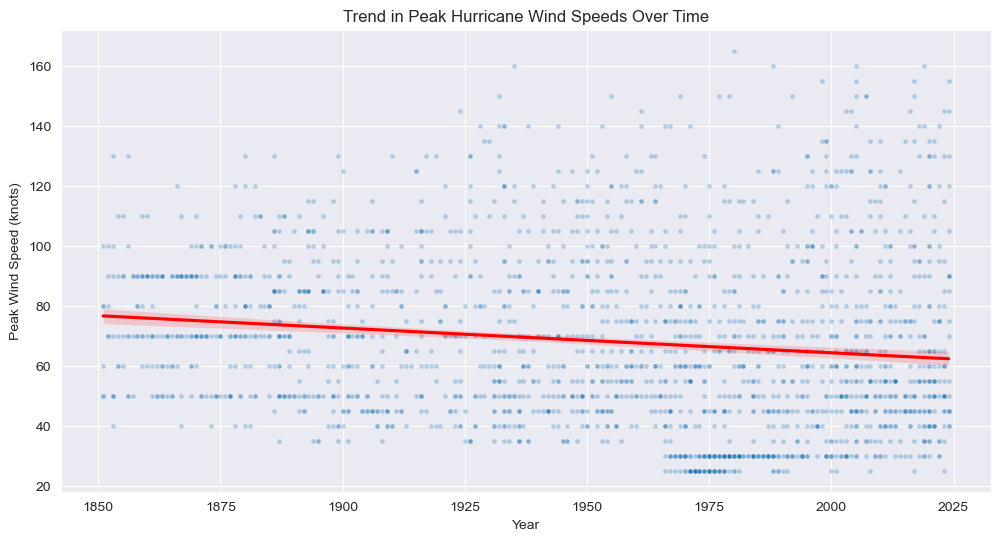

In [ ]:
df['date_str'] = df['date'].astype(str)
df['time_str'] = df['time'].astype(str).str.zfill(4)
df['datetime_str'] = (df['date'].astype(str).str.strip() +
                      df['time'].astype(str).str.zfill(4).str.strip())
df['datetime'] = pd.to_datetime(df['datetime_str'], format='%Y%m%d%H%M')
print(df[['date','time','datetime']].head())

storm_peaks = df.groupby(['storm_id', 'year'])['max_sustained_wind_knots'].max().reset_index()

plt.figure(figsize=(12,6))
sns.scatterplot(
    data=storm_peaks,
    x='year',
    y='max_sustained_wind_knots',
    s=12,
    alpha=0.3
)
sns.regplot(
    data=storm_peaks,
    x='year',
    y='max_sustained_wind_knots',
    scatter=False,
    color='red'
)
plt.title("Trend in Peak Hurricane Wind Speeds Over Time")
plt.xlabel("Year")
plt.ylabel("Peak Wind Speed (knots)")
plt.grid(True)
plt.show()


## Areas of Highest Frequency x Intensity Combination 

In [ ]:
df['lat_bin'] = pd.cut(df['latitude'], bins=range(-10, 60, 5))
df['lon_bin'] = pd.cut(df['longitude'], bins=range(-110, 10, 5))

area_stats = df.groupby(['lat_bin', 'lon_bin']).agg(
    frequency=('storm_id', 'count'),
    avg_intensity=('max_sustained_wind_knots', 'mean'),
    max_intensity=('max_sustained_wind_knots', 'max')
).reset_index()

area_stats['score'] = area_stats['frequency'] * area_stats['avg_intensity']

top_areas = area_stats.sort_values('score', ascending=False).head(10)
print(top_areas)

      lat_bin     lon_bin  frequency  avg_intensity  max_intensity    score
190  (30, 35]  (-80, -75]       1529      53.559189          130.0  81892.0
167  (25, 30]  (-80, -75]       1321      58.319455          160.0  77040.0
191  (30, 35]  (-75, -70]       1250      58.292000          120.0  72865.0
165  (25, 30]  (-90, -85]       1265      56.574704          150.0  71567.0
164  (25, 30]  (-95, -90]       1225      56.212245          130.0  68860.0
120  (15, 20]  (-85, -80]       1254      53.018341          160.0  66485.0
166  (25, 30]  (-85, -80]       1244      52.668006          160.0  65519.0
169  (25, 30]  (-70, -65]        996      64.026104          135.0  63770.0
143  (20, 25]  (-85, -80]       1071      59.154995          160.0  63355.0
142  (20, 25]  (-90, -85]       1076      58.094796          165.0  62510.0


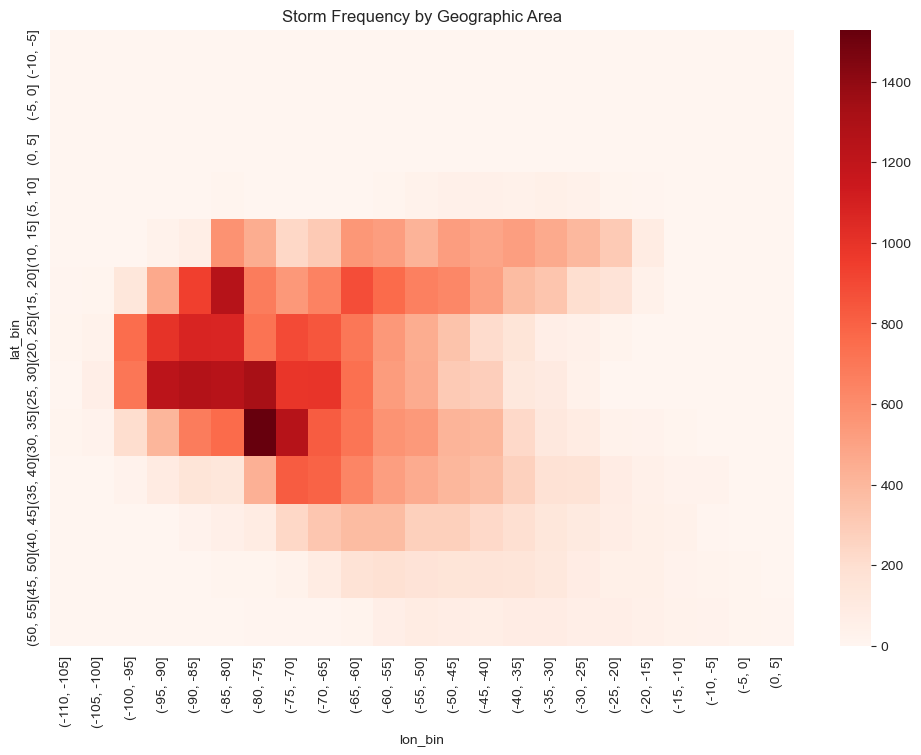

In [ ]:
freq_map = area_stats.pivot_table(
    index='lat_bin', columns='lon_bin', values='frequency'
)

plt.figure(figsize=(12,8))
sns.heatmap(freq_map, cmap='Reds')
plt.title("Storm Frequency by Geographic Area")
plt.show();


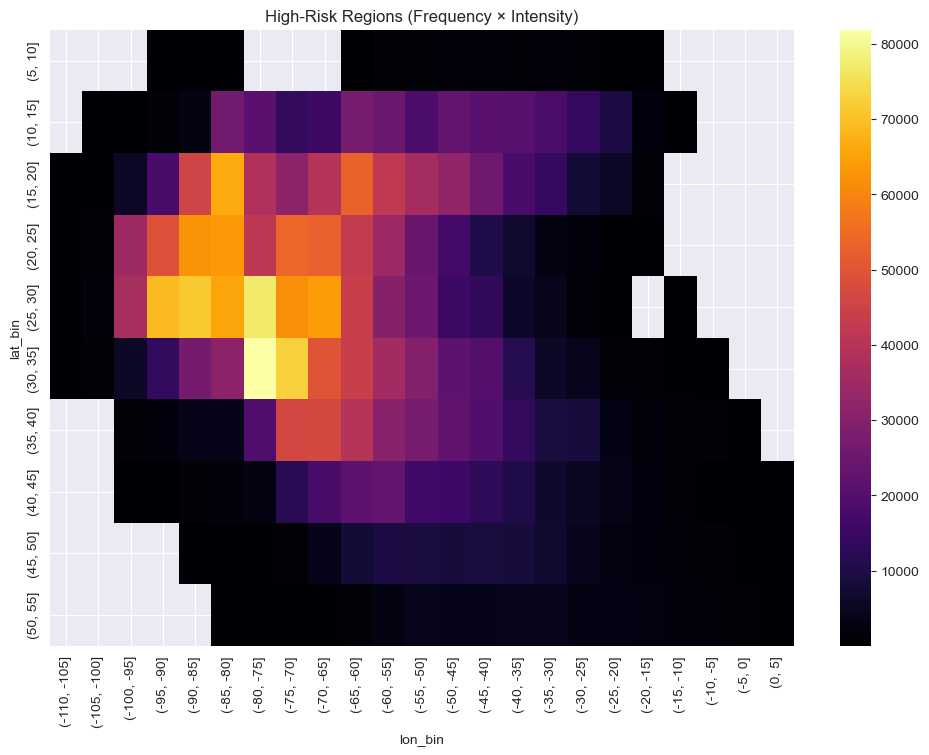

In [ ]:
score_map = area_stats.pivot_table(
    index='lat_bin', columns='lon_bin', values='score'
)

plt.figure(figsize=(12,8))
sns.heatmap(score_map, cmap='inferno')
plt.title("High-Risk Regions (Frequency × Intensity)")
plt.show()


## Distribution of Landfall

In [ ]:
landfalls = df[df['record_identifier'] == "Landfall (center of system crossing a coastline)"].copy()
landfalls['year'] = landfalls['datetime'].dt.year
landfalls['month'] = landfalls['datetime'].dt.month

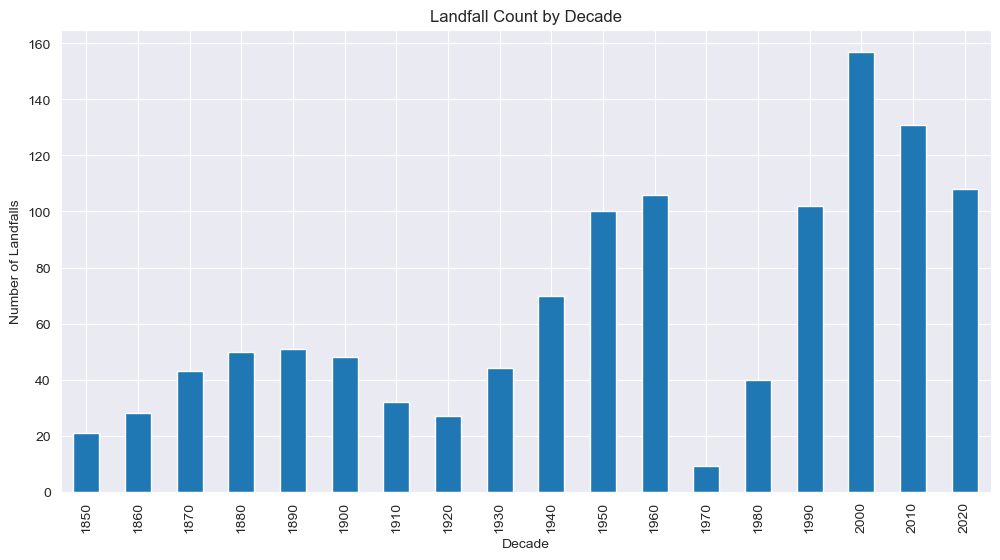

In [ ]:
landfalls['decade'] = (landfalls['year'] // 10) * 10

landfalls_per_decade = landfalls['decade'].value_counts().sort_index()

plt.figure(figsize=(12,6))
landfalls_per_decade.plot(kind='bar')
plt.title("Landfall Count by Decade")
plt.xlabel("Decade")
plt.ylabel("Number of Landfalls")
plt.grid(True)
plt.show()

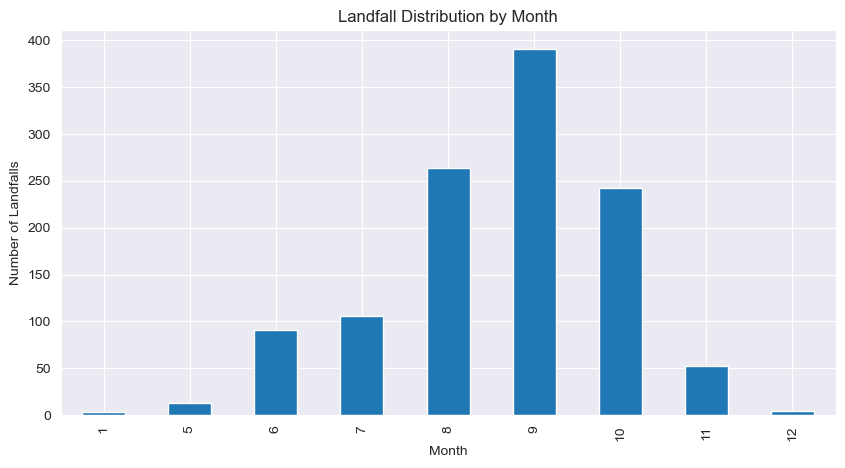

In [ ]:
landfalls_per_month = landfalls['month'].value_counts().sort_index()

plt.figure(figsize=(10,5))
landfalls_per_month.plot(kind='bar')
plt.title("Landfall Distribution by Month")
plt.xlabel("Month")
plt.ylabel("Number of Landfalls")
plt.grid(True)
plt.show()


In [ ]:
landfalls_summary = landfalls.groupby('year').size().describe()
print(landfalls_summary)

count    158.000000
mean       7.386076
std        6.205324
min        1.000000
25%        3.000000
50%        6.000000
75%        9.000000
max       34.000000
dtype: float64


## Geographic Location and Hurricane Intensity 

In [ ]:
df['lat_bin'] = pd.cut(df['latitude'], bins=range(-10, 60, 5))
df['lon_bin'] = pd.cut(df['longitude'], bins=range(-110, 10, 5))

area_intensity = df.groupby(['lat_bin', 'lon_bin'], observed=True).agg(
    avg_wind=('max_sustained_wind_knots', 'mean'),
    max_wind=('max_sustained_wind_knots', 'max'),
    count=('storm_id', 'count')
).reset_index()


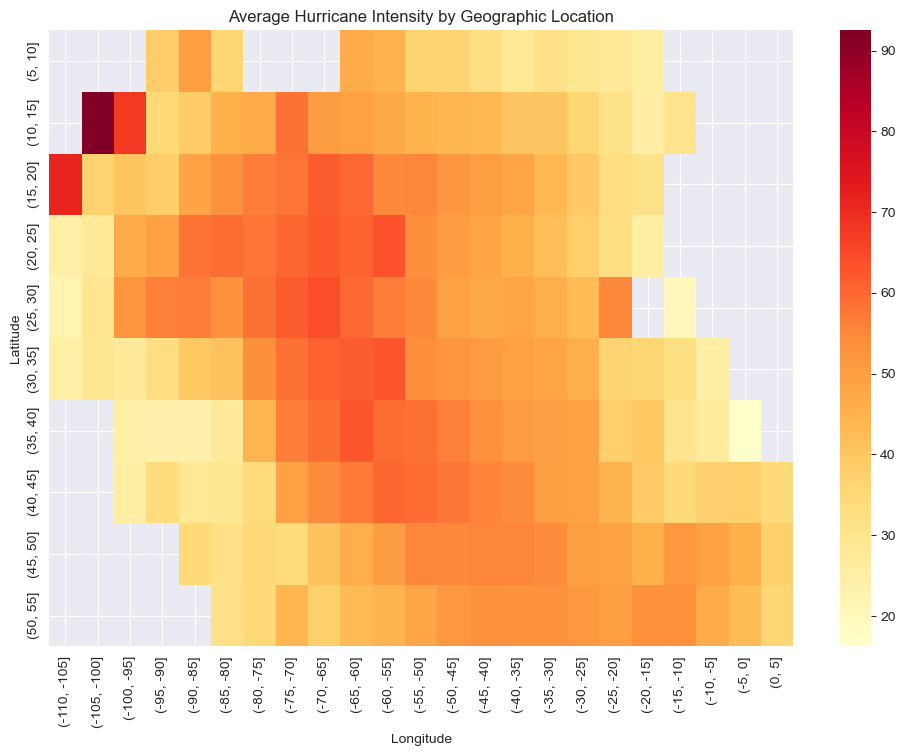

In [ ]:
heatmap_data = area_intensity.pivot_table(index='lat_bin', columns='lon_bin', values='avg_wind')

plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data, cmap='YlOrRd')
plt.title("Average Hurricane Intensity by Geographic Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

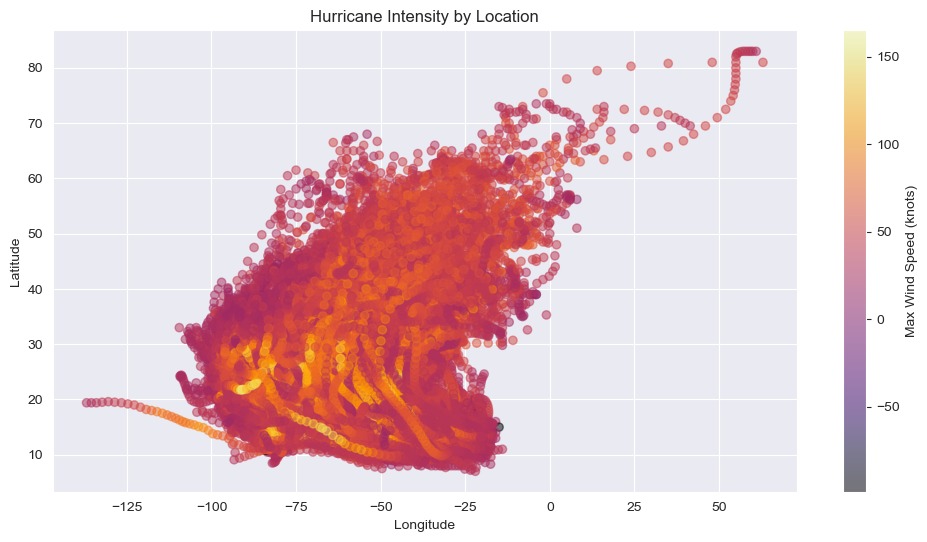

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(df['longitude'], df['latitude'], c=df['max_sustained_wind_knots'],
            cmap='inferno', alpha=0.5)
plt.colorbar(label='Max Wind Speed (knots)')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Hurricane Intensity by Location")
plt.grid(True)
plt.show()

In [ ]:
# Correlation between latitude and max wind
lat_corr = df[['latitude','max_sustained_wind_knots']].corr().iloc[0,1]
lon_corr = df[['longitude','max_sustained_wind_knots']].corr().iloc[0,1]

print(f"Correlation latitude vs intensity: {lat_corr:.2f}")
print(f"Correlation longitude vs intensity: {lon_corr:.2f}")


Correlation latitude vs intensity: 0.04
Correlation longitude vs intensity: -0.05


## Are Hurricanes Getting Stronger Over Time? 

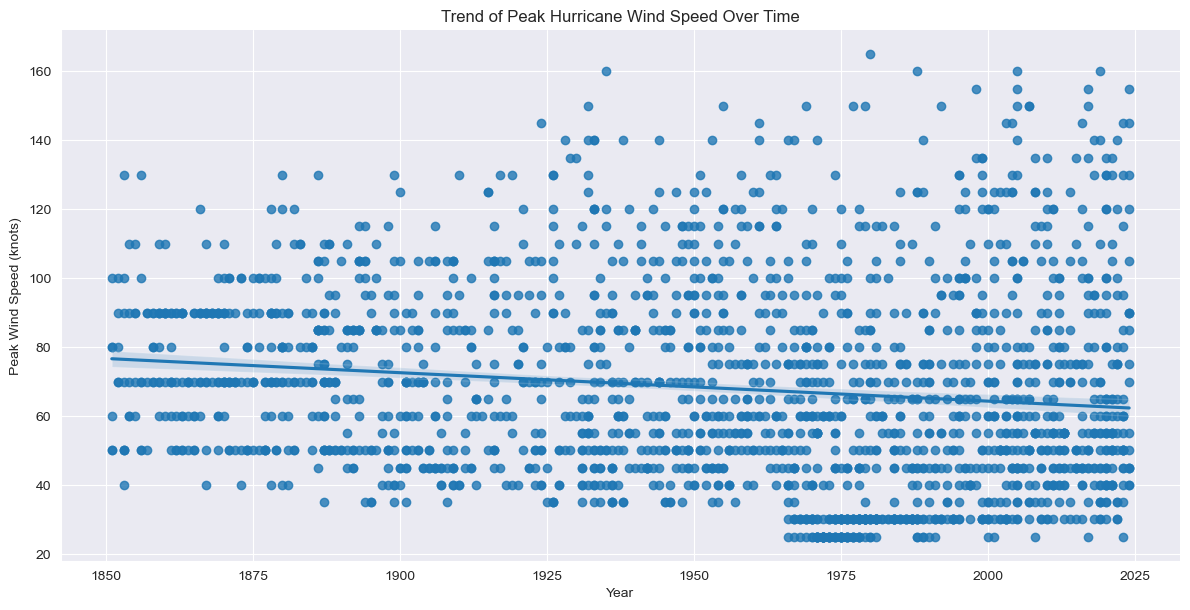

In [ ]:
storm_peaks = df.groupby(['storm_id', 'year'])['max_sustained_wind_knots'].max().reset_index()


sns.lmplot(data=storm_peaks, x='year', y='max_sustained_wind_knots', height=6, aspect=2)
plt.xlabel("Year")
plt.ylabel("Peak Wind Speed (knots)")
plt.title("Trend of Peak Hurricane Wind Speed Over Time")
plt.show()


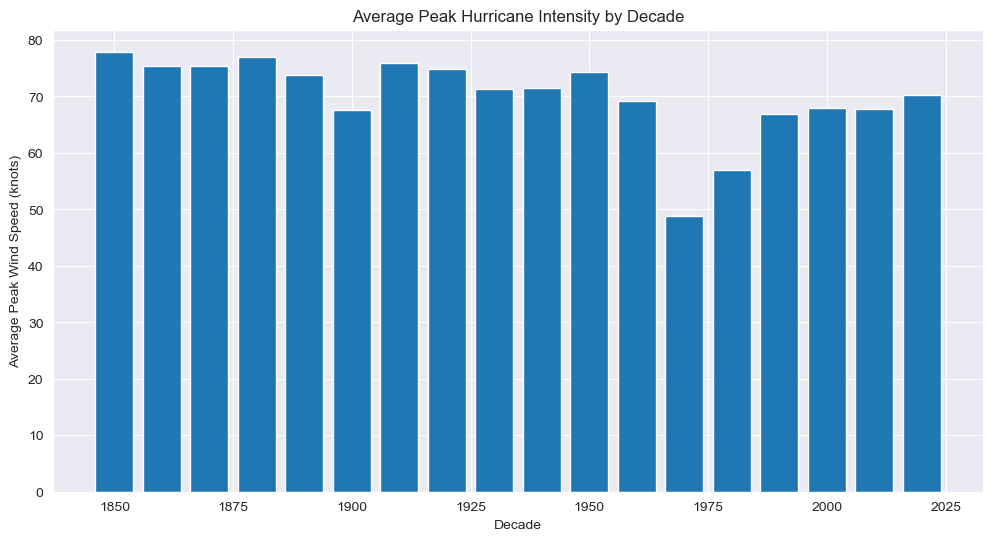

In [ ]:
storm_peaks['decade'] = (storm_peaks['year'] // 10) * 10
decade_avg = storm_peaks.groupby('decade')['max_sustained_wind_knots'].mean().reset_index()

plt.figure(figsize=(12,6))
plt.bar(decade_avg['decade'], decade_avg['max_sustained_wind_knots'], width=8)
plt.xlabel("Decade")
plt.ylabel("Average Peak Wind Speed (knots)")
plt.title("Average Peak Hurricane Intensity by Decade")
plt.grid(True)
plt.show()


## Landfalling Hurricanes that are Major (CAT 3+)

In [ ]:
landfalls = df[df['record_identifier'] == "Landfall (center of system crossing a coastline)"].copy()
major_landfalls = landfalls[landfalls['storm_category'].isin(['Category 3', 'Category 4', 'Category 5'])]
percentage_major = len(major_landfalls) / len(landfalls) * 100

print(f"Percentage of landfalls that are major hurricanes: {percentage_major:.2f}%")

Percentage of landfalls that are major hurricanes: 17.74%


In [ ]:
landfalls['storm_category'].value_counts()

storm_category
TS            521
Category 1    251
Category 2    145
Category 3    122
Category 4     66
TD             43
Category 5     19
Name: count, dtype: int64

***